In [126]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Georgia

## Election Results Documentation:

Election results from the Georgia Secretary of State Elections Division (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results). Presidential recount results from the Georgia Secretary of State Elections Division via Reuters.

## Shapefile Source Documentation:

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  
Cobb, DeKalb, and Gwinnett counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program.  
Forsyth and Fulton use shapefiles sourced from the respective counties.

## Shapefile Modifications Documentation:

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election.

Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary  
Bartow: Split Cassville/Hamilton Crossing  
Candler: Merge Candler/Metter as Jack Strickland Comm Center  
Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C  
Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile  
Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5   
Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B  
Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps  
Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre  
Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035  
DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits   
Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G  
Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU  
Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits  
Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019  
Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman  
Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps  
Towns: Merge Macedonia/Tate City  
Wilkes: Align 1/2A boundary with the voter file    
Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

## Candidate List

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
  
C20PRERTRU - Donald J. Trump (Republican Party)  
C20PREDBID - Joseph R. Biden (Democratic Party)  
C20PRELJOR - Jo Jorgensen (Libertarian Party)  
  
G20USSRPER - David A. Perdue (Republican Party)  
G20USSDOSS - Jon Ossoff (Democratic Party)  
G20USSLHAZ - Shane Hazel (Libertarian Party)  
  
S20USSRLOE - Kelly Loeffler (Republican Party)  
S20USSRCOL - Doug Collins (Republican Party)  
S20USSRGRA - Derrick E. Grayson (Republican Party)  
S20USSRJAC - Annette Davis Jackson (Republican Party)  
S20USSRTAY - Kandiss Taylor (Republican Party)  
S20USSRJOH - A. Wayne Johnson (Republican Party)  
S20USSDWAR - Raphael Warnock (Democratic Party)  
S20USSDJAC - Deborah Jackson (Democratic Party)  
S20USSDLIE - Matt Lieberman (Democratic Party)  
S20USSDJOH - Tamara Johnson-Shealey (Democratic Party)  
S20USSDJAM - Jamesia James (Democratic Party)  
S20USSDSLA - Joy Felicia Slade (Democratic Party)  
S20USSDWIN - Richard Dien Winfield (Democratic Party)  
S20USSDTAR - Ed Tarver (Democratic Party)  
S20USSLSLO - Brian Slowinski (Libertarian Party)  
S20USSGFOR - John Fortuin (Green Party)  
S20USSIBUC - Allen Buckley (Independent)  
S20USSIBAR - Al Bartell (Independent)  
S20USSISTO - Valencia Stovall (Independent)  
S20USSIGRE - Michael Todd Greene (Independent)  
  
G20PSCRSHA - Jason Shaw (Republican Party)  
G20PSCDBRY - Robert G. Bryant (Democratic Party)  
G20PSCLMEL - Elizabeth Melton (Libertarian Party)  
  
G20PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)  
G20PSCDBLA - Daniel Blackman (Democratic Party)  
G20PSCLWIL - Nathan Wilson (Libertarian Party)  

R21USSRPER - David A. Perdue (Republican Party)  
R21USSDOSS - Jon Ossoff (Democratic Party)  

R21USSRLOE - Kelly Loeffler (Republican Party)  
R21USSDWAR - Raphael Warnock (Democratic Party)  

R21PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)  
P21PSCDBLA - Daniel Blackman (Democratic Party)  

## Election Results Processing

### Load the VEST file

In [127]:
vest_ga_20 = gp.read_file("./raw-from-source/VEST/ga_2020/ga_2020.shp")
print(vest_ga_20.shape)

(2679, 50)


In [128]:
# Take a look
vest_ga_20.head(1)

#Create a list of the race columns
data_columns = [i for i in vest_ga_20.columns if (("20" in i) | ("21" in i))]
print(data_columns)

['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER', 'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA', 'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC', 'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN', 'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR', 'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL', 'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS', 'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA']


### 1. Load General Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [129]:
loaded_counties = os.listdir("./raw-from-source/Non_Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Non_Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_general = pd.DataFrame(z,columns=dfcols)

### 2. Load Recount Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [130]:
loaded_counties = os.listdir("./raw-from-source/Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_recount = pd.DataFrame(z,columns=dfcols)

### 3. Load Runoff Election Data

In [131]:
loaded_counties = os.listdir("./raw-from-source/Runoff_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Runoff_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_runoff = pd.DataFrame(z,columns=dfcols)

### Clean Recount Data - Contest Names

Note: Doing this before combining with the other data so the presidential vote tallies don't get mixed up

In [132]:
print(df_recount["contest"].unique())

contest_changes_dict = {'President of the United States':'President-Recount',
 'President of the United States/Presidentede los Estados Unidos':'President-Recount'}

df_recount["contest"] = df_recount["contest"].map(contest_changes_dict).fillna(df_recount["contest"])
print(df_recount["contest"].unique())

['President of the United States'
 'President of the United States/Presidentede los Estados Unidos']
['President-Recount']


### Clean Runoff Data - Contest Names

Note: Doing this before combining with the other data so the presidential vote tallies don't get mixed up

In [133]:
print(df_runoff["contest"].unique())

contest_changes_dict = {'US Senate (Perdue)':'US Senate (Perdue) - runoff', 
                        'US Senate (Loeffler) - Special':'US Senate (Loeffler) - Special - runoff',
                        'Public Service Commission District 4':'Public Service Commission District 4 - runoff',
                        'US Senate (Perdue)/Senado de los EE.UU. (Perdue)':'US Senate (Perdue) - runoff',
                        'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial':'US Senate (Loeffler) - Special - runoff',
                        'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4':'Public Service Commission District 4 - runoff'}

df_runoff["contest"] = df_runoff["contest"].map(contest_changes_dict).fillna(df_runoff["contest"])
print(df_runoff["contest"].unique())

['US Senate (Perdue)' 'US Senate (Loeffler) - Special'
 'Public Service Commission District 4'
 'Crawfordville City Council Post 4 - Special\r\n'
 'County Commission District 1' 'County Commission District 2'
 'Board of Education District 2 - Special'
 'US Senate (Perdue)/Senado de los EE.UU. (Perdue)'
 'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial'
 'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4']
['US Senate (Perdue) - runoff' 'US Senate (Loeffler) - Special - runoff'
 'Public Service Commission District 4 - runoff'
 'Crawfordville City Council Post 4 - Special\r\n'
 'County Commission District 1' 'County Commission District 2'
 'Board of Education District 2 - Special']


### Join Election Data Together

In [134]:
ga_election = pd.concat([df_general,df_recount,df_runoff])

#Sanity check that there are the right number of counties
print(len(ga_election["county"].unique()))

159


### Look into US House, State House, and State Senate Districts (for the ERJ project)

In [135]:
race_name_change_dict = {
    'US House Dist 4/Distrito del Congreso 4':'US House District 4',
    'US House Dist 7/Distrito del Congreso 7':'US House District 7',
    'US House Dist 10/Distrito del Congreso 10':'US House District 10',
    'State House Dist 81/Estatal ante la Asamblea General Dist 81':'State House District 81',
    'State House Dist 93/Estatal ante la Asamblea General Dist 93':'State House District 93',
    'State House Dist 94/Estatal ante la Asamblea General Dist 94':'State House District 94',
    'State House Dist 95/Estatal ante la Asamblea General Dist 95':'State House District 95',
    'State House Dist 96/Estatal ante la Asamblea General Dist 96':'State House District 96',
    'State House Dist 97/Estatal ante la Asamblea General Dist 97':'State House District 97',
    'State House Dist 98/Estatal ante la Asamblea General Dist 98':'State House District 98',
    'State House Dist 99/Estatal ante la Asamblea General Dist 99':'State House District 99',
    'State House Dist 100/Estatal ante la Asamblea General Dist 100':'State House District 100',
    'State House Dist 101/Estatal ante la Asamblea General Dist 101':'State House District 101',
    'State House Dist 102/Estatal ante la Asamblea General Dist 102':'State House District 102',
    'State House Dist 103/Estatal ante la Asamblea General Dist 103':'State House District 103',
    'State House Dist 104/Estatal ante la Asamblea General Dist 104':'State House District 104',
    'State House Dist 105/Estatal ante la Asamblea General Dist 105':'State House District 105',
    'State House Dist 106/Estatal ante la Asamblea General Dist 106':'State House District 106',
    'State House Dist 107/Estatal ante la Asamblea General Dist 107':'State House District 107', 
    'State House Dist 108/Estatal ante la Asamblea General Dist 108':'State House District 108', 
    'State House Dist 114/Estatal ante la Asamblea General Dist 114':'State House District 114',
    'State Senate Dist 5/Senador Estatal Dist 5':'State Senate District 5',
    'State Senate Dist 9/Senador Estatal Dist 9':'State Senate District 9',
    'State Senate Dist 40/Senador Estatal Dist 40':'State Senate District 40',
    'State Senate Dist 41/Senador Estatal Dist 41':'State Senate District 41',
    'State Senate Dist 45/Senador Estatal Dist 45':'State Senate District 45',
    'State Senate Dist 48/Senador Estatal Dist 48':'State Senate District 48',
    'State Senate Dist 55/Senador Estatal Dist 55':'State Senate District 55'
}

ga_election["contest"] = ga_election["contest"].map(race_name_change_dict).fillna(ga_election["contest"])

In [136]:
total_races_list = list(ga_election["contest"].unique())

possible_us_house_races = [i for i in total_races_list if "US House" in i]
possible_ga_house_races = [i for i in total_races_list if "State House" in i]
possible_ga_senate_races = [i for i in total_races_list if "State Senate" in i]

In [137]:
#14 seats
print(len(possible_us_house_races))
#print(possible_us_house_races)

#180 seats
print(len(possible_ga_house_races))
#print(possible_ga_house_races)

#56 seats
print(len(possible_ga_senate_races))
#print(possible_ga_senate_races)

14
180
56


### Filter Down to Relevant Races

In [138]:
office_list = ['President of the United States','US Senate (Perdue)','US Senate (Loeffler) - Special',
              'Public Service Commission District 1','Public Service Commission District 4',
              'US Senate (Loeffler) - Special Election','President-Recount','President of the United States/Presidentede los Estados Unidos',
              'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1',
       'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4','US Senate (Perdue)/Senado de los EE.UU. (Perdue)',
       'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial','US Senate (Perdue) - runoff','US Senate (Loeffler) - Special - runoff','Public Service Commission District 4 - runoff']

ga_election = ga_election[ga_election["contest"].isin(office_list)]

### Clean and Pivot Data

In [139]:
list(ga_election["contest"].unique())

['President of the United States',
 'US Senate (Perdue)',
 'US Senate (Loeffler) - Special',
 'Public Service Commission District 1',
 'Public Service Commission District 4',
 'US Senate (Loeffler) - Special Election',
 'President of the United States/Presidentede los Estados Unidos',
 'US Senate (Perdue)/Senado de los EE.UU. (Perdue)',
 'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial',
 'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1',
 'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4',
 'President-Recount',
 'US Senate (Perdue) - runoff',
 'US Senate (Loeffler) - Special - runoff',
 'Public Service Commission District 4 - runoff']

In [140]:
print(ga_election["contest"].unique())

contest_changes_dict = {
 'US Senate (Loeffler) - Special Election':'US Senate (Loeffler) - Special',
 'President of the United States/Presidentede los Estados Unidos':'President of the United States',
 'US Senate (Perdue)/Senado de los EE.UU. (Perdue)':'US Senate (Perdue)',
 'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial':'US Senate (Loeffler) - Special',
 'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1':'Public Service Commission District 1',
 'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4':'Public Service Commission District 4'}

ga_election["contest"] = ga_election["contest"].map(contest_changes_dict).fillna(ga_election["contest"])
print(ga_election["contest"].unique())

['President of the United States' 'US Senate (Perdue)'
 'US Senate (Loeffler) - Special' 'Public Service Commission District 1'
 'Public Service Commission District 4'
 'US Senate (Loeffler) - Special Election'
 'President of the United States/Presidentede los Estados Unidos'
 'US Senate (Perdue)/Senado de los EE.UU. (Perdue)'
 'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial'
 'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1'
 'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4'
 'President-Recount' 'US Senate (Perdue) - runoff'
 'US Senate (Loeffler) - Special - runoff'
 'Public Service Commission District 4 - runoff']
['President of the United States' 'US Senate (Perdue)'
 'US Senate (Loeffler) - Special' 'Public Service Commission District 1'
 'Public Service Commission District 4' 'President-Recount'
 'US Senate (Perdue) - runoff' 'US Senate (Loeffler) - Special - runoff'
 'Public Service Commission District 4 

### Clean Candidate Names

In [141]:
print(ga_election["choice"].unique())

['Donald J. Trump (I) (Rep)' 'Joseph R. Biden (Dem)' 'Jo Jorgensen (Lib)'
 'David A. Perdue (I) (Rep)' 'Jon Ossoff (Dem)' 'Shane Hazel (Lib)'
 'Al Bartell (Ind)' 'Allen Buckley (Ind)' 'Doug Collins (Rep)'
 'John Fortuin (Grn)' 'Derrick E. Grayson (Rep)'
 'Michael Todd Greene (Ind)' 'Annette Davis Jackson (Rep)'
 'Deborah Jackson (Dem)' 'Jamesia James (Dem)' 'A. Wayne Johnson (Rep)'
 'Tamara Johnson-Shealey (Dem)' 'Matt Lieberman (Dem)'
 'Kelly Loeffler (I) (Rep)' 'Joy Felicia Slade (Dem)'
 'Brian Slowinski (Lib)' 'Valencia Stovall (Ind)' 'Ed Tarver (Dem)'
 'Kandiss Taylor (Rep)' 'Raphael Warnock (Dem)'
 'Richard Dien Winfield (Dem)' 'Jason Shaw (I) (Rep)'
 'Robert G. Bryant (Dem)' 'Elizabeth Melton (Lib)'
 'Lauren Bubba McDonald, Jr. (I) (Rep)' 'Daniel Blackman (Dem)'
 'Nathan Wilson (Lib)' 'Matt Lierberman (Dem)']


#### Correct the Candidate Name Typo

In [142]:
cand_change_dict = {'Matt Lierberman (Dem)':'Matt Lieberman (Dem)'}
ga_election["choice"] = ga_election["choice"].map(cand_change_dict).fillna(ga_election["choice"])

In [143]:
ga_election["num_votes"] = ga_election["num_votes"].astype(int)

#### Add a FIPS Column

In [144]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
ga_election['county_fips'] = ga_election['county'].map(fips_dict).fillna(ga_election['county'])
ga_election['county_fips'] = ga_election['county_fips'].astype(str)
ga_election['county_fips'] = ga_election['county_fips'].str.zfill(3)

In [145]:
ga_election['county_fips'].unique()

array(['081', '029', '027', '017', '219', '245', '275', '277', '239',
       '221', '095', '105', '107', '003', '103', '033', '273', '251',
       '249', '271', '113', '025', '083', '021', '037', '263', '257',
       '261', '265', '115', '099', '005', '009', '035', '101', '247',
       '269', '243', '241', '267', '253', '023', '111', '007', '131',
       '129', '183', '163', '287', '317', '315', '293', '177', '181',
       '045', '055', '125', '049', '077', '173', '193', '307', '283',
       '285', '309', '179', '175', '161', '133', '047', '071', '121',
       '137', '297', '295', '167', '189', '197', '165', '291', '305',
       '053', '117', '147', '059', '043', '303', '311', '191', '169',
       '159', '187', '313', '289', '123', '135', '073', '065', '201',
       '195', '149', '153', '067', '151', '141', '301', '299', '057',
       '069', '145', '127', '139', '075', '319', '321', '157', '063',
       '051', '155', '143', '171', '185', '061', '079', '011', '119',
       '259', '199',

#### Pivot the data

In [146]:
ga_election["unique_ID"]=ga_election["county_fips"]+ga_election["precinct"]
ga_election["choice"]=ga_election["choice"]+ga_election["contest"]
ga_election=pd.pivot_table(ga_election,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
ga_election = ga_election.fillna(0)
ga_election.columns = ga_election.columns.droplevel(0)
ga_election = ga_election.reset_index()

#### Change Names to match VEST

In [147]:
column_changes_dict = {'A. Wayne Johnson (Rep)US Senate (Loeffler) - Special':'S20USSRJOH',
        'Al Bartell (Ind)US Senate (Loeffler) - Special':'S20USSIBAR',
        'Allen Buckley (Ind)US Senate (Loeffler) - Special':'S20USSIBUC',
        'Annette Davis Jackson (Rep)US Senate (Loeffler) - Special':'S20USSRJAC',
        'Brian Slowinski (Lib)US Senate (Loeffler) - Special':'S20USSLSLO',
        'Daniel Blackman (Dem)Public Service Commission District 4':'G20PSCDBLA',
        'David A. Perdue (I) (Rep)US Senate (Perdue)':'G20USSRPER',
        'Deborah Jackson (Dem)US Senate (Loeffler) - Special':'S20USSDJAC',
        'Derrick E. Grayson (Rep)US Senate (Loeffler) - Special':'S20USSRGRA',
        'Donald J. Trump (I) (Rep)President of the United States':'G20PRERTRU',
        'Donald J. Trump (I) (Rep)President-Recount':'C20PRERTRU',
        'Doug Collins (Rep)US Senate (Loeffler) - Special':'S20USSRCOL',
        'Ed Tarver (Dem)US Senate (Loeffler) - Special':'S20USSDTAR',
        'Elizabeth Melton (Lib)Public Service Commission District 1':'G20PSCLMEL',
        'Jamesia James (Dem)US Senate (Loeffler) - Special':'S20USSDJAM',
        'Jason Shaw (I) (Rep)Public Service Commission District 1':'G20PSCRSHA',
        'Jo Jorgensen (Lib)President of the United States':'G20PRELJOR',
        'Jo Jorgensen (Lib)President-Recount':'C20PRELJOR',
        'John Fortuin (Grn)US Senate (Loeffler) - Special':'S20USSGFOR',
        'Jon Ossoff (Dem)US Senate (Perdue)':'G20USSDOSS',
        'Joseph R. Biden (Dem)President of the United States':'G20PREDBID',
        'Joseph R. Biden (Dem)President-Recount':'C20PREDBID',
        'Joy Felicia Slade (Dem)US Senate (Loeffler) - Special':'S20USSDSLA',
        'Kandiss Taylor (Rep)US Senate (Loeffler) - Special':'S20USSRTAY',
        'Kelly Loeffler (I) (Rep)US Senate (Loeffler) - Special':'S20USSRLOE',
        'Lauren Bubba McDonald, Jr. (I) (Rep)Public Service Commission District 4':'G20PSCRMCD',
        'Matt Lieberman (Dem)US Senate (Loeffler) - Special':'S20USSDLIE',
        'Michael Todd Greene (Ind)US Senate (Loeffler) - Special':'S20USSIGRE',
        'Nathan Wilson (Lib)Public Service Commission District 4':'G20PSCLWIL',
        'Raphael Warnock (Dem)US Senate (Loeffler) - Special':'S20USSDWAR',
        'Richard Dien Winfield (Dem)US Senate (Loeffler) - Special':'S20USSDWIN',
        'Robert G. Bryant (Dem)Public Service Commission District 1':'G20PSCDBRY',
        'Shane Hazel (Lib)US Senate (Perdue)':'G20USSLHAZ',
        'Tamara Johnson-Shealey (Dem)US Senate (Loeffler) - Special':'S20USSDJOH',
        'Valencia Stovall (Ind)US Senate (Loeffler) - Special':'S20USSISTO',
        'Daniel Blackman (Dem)Public Service Commission District 4 - runoff':'R21PSCDBLA',
        'David A. Perdue (I) (Rep)US Senate (Perdue) - runoff':'R21USSRPER',
        'Jon Ossoff (Dem)US Senate (Perdue) - runoff':'R21USSDOSS',
        'Kelly Loeffler (I) (Rep)US Senate (Loeffler) - Special - runoff':'R21USSRLOE',
        'Lauren Bubba McDonald, Jr. (I) (Rep)Public Service Commission District 4 - runoff':'R21PSCRMCD',
        'Raphael Warnock (Dem)US Senate (Loeffler) - Special - runoff':'R21USSDWAR'}

ga_election = ga_election.rename(columns=column_changes_dict)

In [148]:
list(ga_election.columns)

['unique_ID',
 'county',
 'county_fips',
 'precinct',
 'S20USSRJOH',
 'S20USSIBAR',
 'S20USSIBUC',
 'S20USSRJAC',
 'S20USSLSLO',
 'G20PSCDBLA',
 'R21PSCDBLA',
 'G20USSRPER',
 'R21USSRPER',
 'S20USSDJAC',
 'S20USSRGRA',
 'G20PRERTRU',
 'C20PRERTRU',
 'S20USSRCOL',
 'S20USSDTAR',
 'G20PSCLMEL',
 'S20USSDJAM',
 'G20PSCRSHA',
 'G20PRELJOR',
 'C20PRELJOR',
 'S20USSGFOR',
 'G20USSDOSS',
 'R21USSDOSS',
 'G20PREDBID',
 'C20PREDBID',
 'S20USSDSLA',
 'S20USSRTAY',
 'S20USSRLOE',
 'R21USSRLOE',
 'G20PSCRMCD',
 'R21PSCRMCD',
 'S20USSDLIE',
 'S20USSIGRE',
 'G20PSCLWIL',
 'S20USSDWAR',
 'R21USSDWAR',
 'S20USSDWIN',
 'G20PSCDBRY',
 'G20USSLHAZ',
 'S20USSDJOH',
 'S20USSISTO']

#### Order election result columns to match VEST

In [149]:
vest_ga_20.columns

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA', 'geometry'],
      dtype='object')

In [150]:
ga_election = ga_election[['unique_ID', 'county', 'county_fips', 'precinct','G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA']]

### Add in Run-Off Votes in 4 Counties: Camden, Chattooga, Grady, and Greene

Note: Precinct-level election results were not available for the run-off election in these four counties. The results for these counties for these races were added manually to a spreadsheet that is loaded in below.

In [151]:
county_list = ["Camden", "Chattooga", "Grady","Greene"]
print(ga_election[ga_election["county"].isin(county_list)][['county','precinct','R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA']])

choice     county            precinct  R21USSRPER  R21USSDOSS  R21USSRLOE  \
168        Camden           Browntown         0.0         0.0         0.0   
169        Camden      East Kingsland         0.0         0.0         0.0   
170        Camden     Harrietts Bluff         0.0         0.0         0.0   
171        Camden           Kingsland         0.0         0.0         0.0   
172        Camden          Mush Bluff         0.0         0.0         0.0   
173        Camden     North Kingsland         0.0         0.0         0.0   
174        Camden      North St Marys         0.0         0.0         0.0   
175        Camden      South St Marys         0.0         0.0         0.0   
176        Camden            St Marys         0.0         0.0         0.0   
177        Camden             Tarboro         0.0         0.0         0.0   
178        Camden             Waverly         0.0         0.0         0.0   
179        Camden      West Kingsland         0.0         0.0         0.0   

In [152]:
#Filter out these counties
ga_election = ga_election[~ga_election["county"].isin(county_list)]
ga_election.reset_index(drop=True,inplace=True)

In [153]:
#Load in the data for these counties
ga_added_vote_counties = pd.read_csv("./raw-from-source/Runoff_Results/counties_needing_votes.csv")

In [154]:
#Combine the data back together
ga_election = pd.concat([ga_election,ga_added_vote_counties])
ga_election.reset_index(drop=True,inplace=True)

In [156]:
for val in data_columns:
    ga_election[val] = ga_election[val].astype(int)

## Compare Statewide Candidate Totals

In [157]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [158]:
statewide_totals_check(vest_ga_20,ga_election,data_columns)

***Statewide Totals Check***
G20PRERTRU is equal 	VEST / RDH: 2461837
G20PREDBID is equal 	VEST / RDH: 2474507
G20PRELJOR is equal 	VEST / RDH: 62138
C20PRERTRU is equal 	VEST / RDH: 2461854
C20PREDBID is equal 	VEST / RDH: 2473633
C20PRELJOR is equal 	VEST / RDH: 62229
G20USSRPER is equal 	VEST / RDH: 2462617
G20USSDOSS is equal 	VEST / RDH: 2374519
G20USSLHAZ is equal 	VEST / RDH: 115039
S20USSRLOE is equal 	VEST / RDH: 1273214
S20USSRCOL is equal 	VEST / RDH: 980454
S20USSRGRA is equal 	VEST / RDH: 51592
S20USSRJAC is equal 	VEST / RDH: 44335
S20USSRTAY is equal 	VEST / RDH: 40349
S20USSRJOH is equal 	VEST / RDH: 36176
S20USSDWAR is equal 	VEST / RDH: 1617035
S20USSDJAC is equal 	VEST / RDH: 324118
S20USSDLIE is equal 	VEST / RDH: 136021
S20USSDJOH is equal 	VEST / RDH: 106767
S20USSDJAM is equal 	VEST / RDH: 94406
S20USSDSLA is equal 	VEST / RDH: 44945
S20USSDWIN is equal 	VEST / RDH: 28687
S20USSDTAR is equal 	VEST / RDH: 26333
S20USSLSLO is equal 	VEST / RDH: 35431
S20USSGFOR is 

## Compare Countywide Totals

In [159]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)>0):
        print()
        print(diff_counties)

In [160]:
#Create a matching "FIPS2" column in the election results
ga_election["county_fips"] = ga_election["county_fips"].astype(int).astype(str).str.zfill(3)
ga_election["FIPS2"] = ga_election["county_fips"]

vest_ga_20["FIPS2"] = vest_ga_20["FIPS2"].astype(str)

In [161]:
#Take a look at the places where VEST does not have a FIPS for the precinct, should be okay to exclude
vest_ga_20[vest_ga_20["FIPS2"]=="None"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,R21USSRPER,R21USSDOSS,R21USSRLOE,R21USSDWAR,R21PSCRMCD,R21PSCDBLA,geometry
1327,051XFTPU,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-80.96828 32.04402, -80.96876 32.044..."
1445,029FTSTEW,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-81.59263 32.10346, -81.59242 ..."
2123,215FTBEN2,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.93473 32.40556, -84.93448 32.405..."
2126,215FTBEN4,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.91564 32.42299, -84.90945 32.422..."
2144,215FTBEN3,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.93783 32.40666, -84.93765 32.406..."
2227,215ZZZZZZ,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.89892 32.45201, -84.89890 32.452..."
2228,215FTBEN1,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.89897 32.44577, -84.89896 32.449..."


In [162]:
county_totals_check(vest_ga_20[vest_ga_20["FIPS2"]!="None"],ga_election,data_columns,"FIPS2",full_print=False)

***Countywide Totals Check***

G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
C20PRERTRU is equal across all counties
C20PREDBID is equal across all counties
C20PRELJOR is equal across all counties
G20USSRPER is equal across all counties
G20USSDOSS is equal across all counties
G20USSLHAZ is equal across all counties
S20USSRLOE is equal across all counties
S20USSRCOL is equal across all counties
S20USSRGRA is equal across all counties
S20USSRJAC is equal across all counties
S20USSRTAY is equal across all counties
S20USSRJOH is equal across all counties
S20USSDWAR is equal across all counties
S20USSDJAC is equal across all counties
S20USSDLIE is equal across all counties
S20USSDJOH is equal across all counties
S20USSDJAM is equal across all counties
S20USSDSLA is equal across all counties
S20USSDWIN is equal across all counties
S20USSDTAR is equal across all counties
S20USSLSLO is equal across all counties
S20USSGFO

In [163]:
ga_election.groupby(["county"]).sum().to_csv("./source_precinct_votes.csv")

## Compare Precinct-by-Precinct Totals

### Join Election Results to VEST (to eventually validate precinct votes)

#### Try a  unique ID

In [36]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_N"]

#### Check whether there are duplicate IDs

In [37]:
ser = ga_election["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
NaN                        7
051-ELI WHITNEY COMPLEX    2
Name: unique_ID, dtype: int64


In [38]:
#Look into duplicate IDs - ELI WHITNEY
display(vest_ga_20[vest_ga_20["unique_ID"]=="051-ELI WHITNEY COMPLEX"])

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,G20PSCDBLA,G20PSCLWIL,R21USSRPER,R21USSDOSS,R21USSRLOE,R21USSDWAR,R21PSCRMCD,R21PSCDBLA,geometry,unique_ID
2243,0513-15C,0513-15C,3-15C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,278,361,...,325,15,281,329,282,329,284,318,"POLYGON ((-81.02948 32.06200, -81.03000 32.060...",051-ELI WHITNEY COMPLEX
2245,0512-06C,0512-06C,2-06C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,65,335,...,301,19,52,312,53,311,54,300,"POLYGON ((-81.05333 32.07291, -81.05336 32.072...",051-ELI WHITNEY COMPLEX


In [39]:
#Assign new unique IDs, adding in PRECINCT_I to differentiate
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

In [40]:
display(vest_ga_20[vest_ga_20["unique_ID"].isna()])

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,G20PSCDBLA,G20PSCLWIL,R21USSRPER,R21USSDOSS,R21USSRLOE,R21USSDWAR,R21PSCRMCD,R21PSCDBLA,geometry,unique_ID
1327,051XFTPU,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-80.96828 32.04402, -80.96876 32.044...",NaN
1445,029FTSTEW,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-81.59263 32.10346, -81.59242 ...",NaN
2123,215FTBEN2,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.93473 32.40556, -84.93448 32.405...",NaN
2126,215FTBEN4,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.91564 32.42299, -84.90945 32.422...",NaN
2144,215FTBEN3,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.93783 32.40666, -84.93765 32.406...",NaN
2227,215ZZZZZZ,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.89892 32.45201, -84.89890 32.452...",NaN
2228,215FTBEN1,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.89897 32.44577, -84.89896 32.449...",NaN


In [41]:
vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']

#### Confirm there are no duplicate IDs

In [42]:
ser = ga_election["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
Series([], Name: unique_ID, dtype: int64)


In [43]:
#First join attempt
join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]

both          2545
right_only     134
left_only      111
Name: _merge, dtype: int64


In [44]:
#Create a dictionary of ID changes
source_vest_id_changes_dict = {'051-1-17C ISLANDS CHRISTIAN CHURCH': '051-ISLANDS CHRISTIAN CHURCH', '051-7-14C COASTAL CATHEDRAL': '051-COASTAL CATHEDRAL', '051-7-07C ROTHWELL BAPTIST CHURCH': '051-ROTHWELL BAPTIST CHURCH', '051-4-07C WILMINGTON ISLAND UMC': '051-WILMINGTON ISLAND UMC', '051-4-08C WILMINGTON ISLAND PRES CHURCH': '051-WILMINGTON ISLAND PRES CHURCH', '051-1-16C FERGUSON AVE BAPTIST': '051-FERGUSON AVE BAPTIST', '051-7-11C SEVENTH DAY ADV CHURCH': '051-SEVENTH DAY ADV CHURCH', '051-7-16C POOLER RECREATION CENTER GYMNASIUM': '051-POOLER REC CENTER GYM', '051-7-08C BLOOMINGDALE COMM CTR': '051-BLOOMINGDALE COMM CTR', '051-4-13C SKIDAWAY ISLAND PRES CHURCH': '051-SKIDAWAY ISLAND PRES CHURCH', '051-6-10C STATION 3': '051-GEORGETOWN ELEMENTARY', '051-4-12C ST PETERS EPISCOPAL': '051-ST PETERS EPISCOPAL', '051-7-13C SOUTHSIDE FIRE TRNG CTR': '051-SOUTHSIDE FIRE TRNG CTR', '051-4-06C FIRST BAPTIST OF THE ISLAND': '051-FIRST BAPTIST OF THE ISLAND', '051-4-04C LIGHTHOUSE BAPTIST CHURCH': '051-LIGHTHOUSE BAPTIST CHURCH', '051-4-05C ST FRANCIS EPISCOPAL CHURCH': '051-ST FRANCIS EPISCOPAL CHURCH', '051-1-12C ISLE OF HOPE BAPTIST': '051-ISLE OF HOPE BAPTIST', '051-4-02C FRANK MURRAY COMM CENTER': '051-FRANK MURRAY COMM CENTER', '051-7-06C POOLER CITY HALL': '051-POOLER CITY HALL', '051-8-16C ROYAL CINEMAS AND IMAX': '051-ROYAL CINEMAS AND IMAX', '051-6-02C WINDSOR FOREST BAPTIST': '051-WINDSOR FOREST BAPTIST', '051-6-11C BAMBOO FARMS': '051-BAMBOO FARMS', '051-4-15C SKIDAWAY ISLAND STATE PARK': '051-SKIDAWAY ISLAND STATE PARK', '051-6-09C TRINITY LUTHERAN CHURCH': '051-TRINITY LUTHERAN CHURCH', '051-1-01C FIRST PRESBYTERIAN CHURCH': '051-FIRST PRESBYTERIAN CHURCH', '051-4-14C SKIDAWAY ISLAND BAPTIST': '051-SKIDAWAY ISLAND BAPTIST', '051-7-12C POOLER CHURCH': '051-POOLER CHURCH', '051-7-10C PROGRESSIVE REC CENTER': '051-PROGRESSIVE REC CENTER', '051-1-06C CENTRAL CHURCH OF CHRIST': '051-CENTRAL CHURCH OF CHRIST', '051-1-14C COMPASSION CHRISTIAN CHURCH': '051-COMPASSION CHRISTIAN CHURCH', '051-6-03C CRUSADER COMM CENTER': '051-CRUSADER COMM CENTER', '051-4-11C TYBEE ISLAND SCHOOL CAFE': '051-TYBEE ISLAND SCHOOL CAFE', '051-7-09C SAVANNAH HOLY C OF G': '051-SAVANNAH HOLY C OF G', '051-4-10C GUARD HOUSE COMM CTR': '051-GUARD HOUSE COMM CTR', '051-1-08C GRACE UNITED METHODIST CHURCH': '051-GRACE UNITED METHODIST CHURCH', '051-1-10C ST THOMAS EPISCOPAL CHURCH': '051-ST THOMAS EPISCOPAL CHURCH', '051-1-05C JEA BUILDING': '051-JEA BUILDING', '051-1-13C THE SANCTUARY': '051-THE SANCTUARY', '051-7-15C RICE CREEK SCHOOL': '051-RICE CREEK SCHOOL', '051-3-12C THUNDERBOLT MUNI COMPLEX': '051-THUNDERBOLT MUNI COMPLEX', '051-3-13C NEW COV 7 DAY ADV CH': '051-NEW COV 7 DAY ADV CH', '051-7-03C PB EDWARDS GYM': '051-PB EDWARDS GYM', '051-7-01C GARDEN CITY SENIOR CTR': '051-GARDEN CITY SENIOR CTR', '051-6-06C THE LIGHT CHURCH': '051-THE LIGHT CHURCH', '051-7-04C LAKE SHORE COMM CTR': '051-LAKE SHORE COMM CTR', '051-6-05C WINDSOR HALL': '051-WINDSOR HALL', '051-3-02C TEMPLE MICKVE ISRAEL': '051-TEMPLE MICKVE ISRAEL', '051-6-01C WHITE BLUFF PRESBYTERIAN': '051-WHITE BLUFF PRESBYTERIAN', '051-5-11C LARGO-TIBET ELEMENTARY': '051-LARGO-TIBET ELEMENTARY', '051-3-14C OGLETHORPE CHARTER ACADEMY': '051-OGLETHORPE CHARTER ACADEMY', '051-6-08C CHRIST MEMORIAL BAPTIST CHURCH': '051-CHRIST MEMORIAL BAPTIST CHURCH', '051-7-05C WOODLAWN BAPTIST CHURCH': '051-WOODLAWN BAPTIST CHURCH', '051-5-08C SAVANNAH PRIMITIVE BC': '051-SAVANNAH PRIMITIVE BC', '051-8-03C SILK HOPE BAPTIST CHURCH': '051-SILK HOPE BAPTIST CHURCH', '051-3-05C ALDERSGATE YOUTH CENTER': '051-ALDERSGATE YOUTH CENTER', '051-3-09C COKESBURY METHODIST': '051-COKESBURY METHODIST', '051-3-15C ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 3-15C', '051-8-13C SAVANNAH CHRISTIAN': '051-SAVANNAH CHRISTIAN', '051-5-07C STATION 1': '051-ELKS LODGE', '051-2-09C SALVATION ARMY': '051-SALVATION ARMY', '051-3-10C BIBLE BAPTIST CHURCH': '051-BIBLE BAPTIST CHURCH', '051-2-07C CHRIST COMMUNITY CHURCH': '051-CHRIST COMMUNITY CHURCH', '051-3-08C JENKINS HIGH SCHOOL': '051-JENKINS HIGH SCHOOL', '051-5-06C SEED CHURCH': '051-SEED CHURCH', '051-1-09C IMMANUEL BAPTIST CHURCH': '051-IMMANUEL BAPTIST CHURCH', '051-8-02C HELLENIC CENTER': '051-HELLENIC CENTER', '051-2-11C STILLWELL TOWERS': '051-STILLWELL TOWERS', '051-3-11C SOUTHSIDE BAPTIST CHURCH': '051-SOUTHSIDE BAPTIST CHURCH', '051-2-02C BLACKSHEAR COMMUNITY CENTER': '051-BLACKSHEAR COMMUNITY CENTER', '051-5-01C BARTLETT MIDDLE SCHOOL': '051-BARTLETT MIDDLE SCHOOL', '051-2-05C HOLY SPIRIT LUTHERAN CHURCH': '051-HOLY SPIRIT LUTHERAN CHURCH', '051-2-04C FELLOWSHIP OF LOVE CHURCH': '051-FELLOWSHIP OF LOVE CHURCH', '051-2-12C WILLIAMS COURT APTS': '051-WILLIAMS COURT APTS', '051-3-01C OLD COURTHOUSE': '051-OLD COURTHOUSE', '051-2-03C W W LAW CENTER': '051-W W LAW CENTER', '051-8-12C BEACH HIGH SCHOOL': '051-BEACH HIGH SCHOOL', '051-5-10C TATUMVILLE COMMUNITY CENTER': '051-TATUMVILLE COMMUNITY CENTER', '051-8-15C GARDEN CITY REC CENTER': '051-GARDEN CITY REC CENTER', '051-2-06C ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 2-06C', '051-3-03C SAVANNAH HIGH SCHOOL': '051-SAVANNAH HIGH SCHOOL', '051-8-01C CIVIC CENTER': '051-CIVIC CENTER', '051-3-04C FIRST AFRICAN BAPTIST CHURCH': '051-FIRST AFRICAN BAPTIST CHURCH', '051-5-05C LIBERTY CITY COMM CTR': '051-LIBERTY CITY COMM CTR', '051-5-02C SENIOR CITIZENS CENTER': '051-SENIOR CITIZENS CENTER', '051-8-08C RESUR OF OUR LORD CHURCH': '051-RESURRECTION OF OUR LORD CHURCH', '051-8-05C W BROAD ST YMCA': '051-W BROAD ST YMCA', '051-8-06C TOMPKINS REC CENTER': '051-TOMPKINS REC CENTER', '051-8-09C MOSES JACKSON CENTER': '051-MOSES JACKSON CENTER', '051-5-03C BUTLER PRESBYTERIAN CHURCH': '051-BUTLER PRESBYTERIAN CHURCH', '051-8-11C BUTLER ELEMENTARY': '051-BUTLER ELEMENTARY', '051-8-07C WOODVILLE-TOMPKINS TI': '051-WOODVILLE-TOMPKINS TI', '051-8-10C CARVER HEIGHTS COMM CTR': '051-CARVER HEIGHTS COMM CTR', '053-ACTIVITY CENTER': '053-ACTIVITY CENTER (Includes FTBEN 1-3)', '067-POWDERS SPRINGS 1A': '067-POWDER SPRINGS 1A', '067-POWDERS SPRINGS 2A': '067-POWDER SPRINGS 2A', '067-POWDERS SPRINGS 3A': '067-POWDER SPRINGS 3A', '171-CHAPPELL MILL V FD': '171-CHAPPELL MILL VFD', '275-LITTLE OCHLOCKNEE BAPTIST CHURCH': '275-LITTLE OCHLOCKNEE', '299-100': '299-District 1', '299-200A': '299-District 2A', '299-200B': '299-District 2B', '299-300': '299-1231-150B', '299-304': '299-1231-150C', '299-400': '299-1231-151', '299-404': '299-Beach-Bickley', '299-405': '299-Haywood', '299-406': '299-Jamestown', '299-407': '299-Manor', '299-408': '299-Millwood', '299-409': '299-Waresboro', '317-TIGNAL SCH LUNCH RM': '317-TIGNALL SCH LUNCH RM'}

#Apply the changes
ga_election["unique_ID"] = ga_election["unique_ID"].map(source_vest_id_changes_dict).fillna(ga_election["unique_ID"])

In [45]:
#Second join attempt
join_attempt_2 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_2["_merge"].value_counts())

both = join_attempt_2[join_attempt_2["_merge"]=="both"]
left_only = join_attempt_2[join_attempt_2["_merge"]=="left_only"]
right_only = join_attempt_2[join_attempt_2["_merge"]=="right_only"]

both          2656
right_only      23
left_only        0
Name: _merge, dtype: int64


In [46]:
#Confirm that the unjoined precincts contain zero-votes
empty_precincts = []
for index, row in right_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race+"_y"]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["DISTRICT"])
print(len(empty_precincts))  

23


### Add the empty precincts to the election results (this will help with the shape join)

In [47]:
empty_unjoined = vest_ga_20[vest_ga_20["DISTRICT"].isin(empty_precincts)]
empty_unjoined = empty_unjoined[["unique_ID","CTYNAME","FIPS2","PRECINCT_N",'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR',
       'G20USSRPER', 'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL',
       'S20USSRGRA', 'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR',
       'S20USSDJAC', 'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA',
       'S20USSDWIN', 'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC',
       'S20USSIBAR', 'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY',
       'G20PSCLMEL', 'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER',
       'R21USSDOSS', 'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA','FIPS2']]

empty_unjoined.columns = ga_election.columns
ga_election = pd.concat([ga_election,empty_unjoined])

In [48]:
#print(vest_ga_20.loc[vest_ga_20['unique_ID'].isna()])
#vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']
#print(vest_ga_20.loc[vest_ga_20['unique_ID'].isna()])

In [49]:
final_join_attempt = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(final_join_attempt["_merge"].value_counts())

both          2679
left_only        0
right_only       0
Name: _merge, dtype: int64


### Validate election results precinct-by-precinct

In [50]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      Nothing, only prints out an analysis
    """
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [51]:
precinct_votes_check(final_join_attempt,data_columns,False,"unique_ID",print_level=0)


There are  2679  total rows
0  of these rows have election result differences
2679  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]


## Shapefiles 

### Shapefile Sources

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  

The following counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release: Cobb, DeKalb, Gwinnett. Forsyth and Fulton use shapefiles sourced from the respective counties.

### 1. Load Primary Precinct Shapefile

In [52]:
#Load in file
shapefiles_state = gp.read_file("./raw-from-source/Shapefiles/Georgia/vtd2020-shape-4-20-21/VTD2020-Shape.shp")

In [53]:
print(shapefiles_state[shapefiles_state["CTYNAME"]=="COBB"]["PRECINCT_N"].unique())

#### Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B - Completed

['WILLEO 01' 'VININGS 01' 'TERRELL MILL 01' 'SOPE CREEK 02'
 'SOPE CREEK 03' 'ROSWELL 01' 'MT BETHEL 01' 'TIMBER RIDGE 01'
 'MT BETHEL 03' 'FULLERS PARK 01' 'SEWELL MILL 01' 'MURDOCK 01'
 'MT BETHEL 04' 'EASTSIDE 01' 'DODGEN 01' 'CHESTNUT RIDGE 01' 'ROSWELL 02'
 'LOST MOUNTAIN 02' 'FORD 01' 'DURHAM 01' 'KEMP 03' 'FREY 01'
 'LOST MOUNTAIN 04' 'MARS HILL 01' 'KENNESAW 1A' 'BIG SHANTY 01'
 'WADE GREEN 02' 'BIG SHANTY 02' 'MCEACHERN 01' 'LOST MOUNTAIN 01'
 'OREGON 01' 'VAUGHAN 01' 'DICKERSON 01' 'SANDY PLAINS 01' 'POPE 01'
 'MABRY 01' 'DAVIS 01' 'GARRISON MILL 01' 'POST OAK 01' 'HIGHTOWER 01'
 'SHALLOWFORD FALLS 01' 'MCCLURE 01' 'ACWORTH 1A' 'HARMONY-LELAND 01'
 'LINDLEY 01' 'ACWORTH 1B' 'AUSTELL 1A' 'CLARKDALE 01' 'POWDER SPRINGS 2A'
 'COOPER 01' 'OREGON 02' 'CLARKDALE 02' 'MABLETON 02' 'BRYANT 02'
 'RIVERSIDE 01' 'POWDER SPRINGS 1A' 'POWDER SPRINGS 3A' 'LOST MOUNTAIN 03'
 'BIRNEY 02' 'BIRNEY 01' 'MABLETON 03' 'MABLETON 04' 'HARRISON 01'
 'KEMP 01' 'HAYES 01' 'PINE MOUNTAIN 02' 'SMYRNA 7A

#### Filter out Cobb, Gwinnett, DeKalb, Fulton and Forsyth

In [54]:
#Make a copy of just Fulton (found that this was closer to VEST's final file)
filtered_fulton = shapefiles_state[shapefiles_state["FIPS2"]=="121"]

#Cobb, Gwinnett and DeKalb
"13135","13067","13089"

#Fulton and Forsyth
"13121","13117"

filter_list_old = ["135","067","089","121","117"]
filter_list = ["135","117","121"]

shapefiles_state = shapefiles_state[~shapefiles_state["FIPS2"].isin(filter_list)]

### 2. Load Census Redistricting Phase 2 Data

In [55]:
#When downloading from the Census redistricing data program, counties are identified via a FIPS code
fips_codes_old = ["13135","13067","13089"]
fips_codes = ["13135"]

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Shapefiles/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

### 3. Shapefile data from the counties themselves

In [56]:
shapefiles_fulton = gp.read_file("./raw-from-source/Shapefiles/Fulton/Voting_Precincts/Voting_Precincts.shp")

shapefiles_forsyth  = gp.read_file("./raw-from-source/Shapefiles/Forsyth/Voting_Precinct-shp/Voting_Precinct.shp")

<AxesSubplot:>

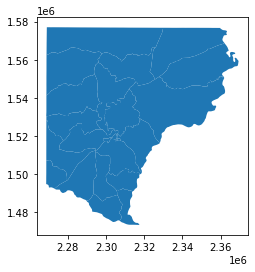

In [57]:
shapefiles_forsyth.plot()

epsg:4019


<AxesSubplot:>

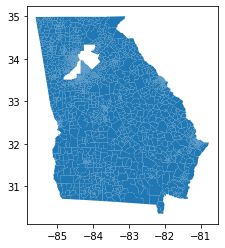

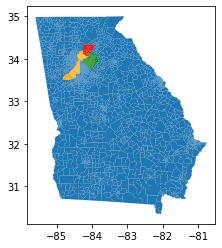

In [58]:
print(vest_ga_20.crs)

shapefiles_forsyth = shapefiles_forsyth.to_crs(4019)
shapefiles_fulton = shapefiles_fulton.to_crs(4019)
shapefiles_census = shapefiles_census.to_crs(4019)

shapefiles_state.plot()

ax = shapefiles_state.plot()
shapefiles_forsyth.plot(ax = ax,color="red")
shapefiles_fulton.plot(ax = ax,color="orange")
shapefiles_census.plot(ax = ax,color="green")

In [59]:
print(shapefiles_state.columns)
print(shapefiles_forsyth.columns)
print(shapefiles_fulton.columns)
print(shapefiles_census.columns)

Index(['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'CNTY', 'FIPS2', 'CTYNAME',
       ...
       'UKNMALEREG', 'UKNMALEVOT', 'UNKMALEVOT', 'UKNFMREG20', 'UKNFMVOTED',
       'UKNFMVOTE1', 'UKNOWNREG2', 'UKNOWNVOTE', 'UKNOWVOTED', 'geometry'],
      dtype='object', length=116)
Index(['OBJECTID', 'PRECINCTID', 'NAME', 'COUNTY', 'Shape__Are', 'Shape__Len',
       'geometry'],
      dtype='object')
Index(['OBJECTID', 'ProposalNo', 'Status', 'RetireStat', 'VoterDist',
       'TurnOut', 'ActVoters', 'FeatureID', 'FacilityID', 'PrecinctN',
       'ShapeSTAre', 'ShapeSTLen', 'geometry'],
      dtype='object')
Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'VTDI', 'LSAD', 'CHNG_TYPE',
       'ORIG_NAME', 'ORIG_CODE', 'RELATE', 'NAME', 'VINTAGE', 'FUNCSTAT',
       'JUSTIFY', 'MTFCC', 'geometry'],
      dtype='object')


In [60]:
display(shapefiles_state.head())

,ID,AREA,DATA,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CNTY,FIPS2,CTYNAME,...,UKNMALEREG,UKNMALEVOT,UNKMALEVOT,UKNFMREG20,UKNFMVOTED,UKNFMVOTE1,UKNOWNREG2,UKNOWNVOTE,UKNOWVOTED,geometry
0,1,3.383541,687,073131,073131,131,JOURNEY COMM. CHURCH,036,073,COLUMBIA,...,40.0,25.0,62.500000,42.0,25.0,59.520000,0.0,0.0,0.0,"POLYGON ((-82.16046 33.55708, -82.16080 33.557..."
1,2,1.636596,667,073064,073064,064,GRACE BAPTIST CHURCH,036,073,COLUMBIA,...,167.0,86.0,51.500000,162.0,100.0,61.730000,0.0,0.0,0.0,"POLYGON ((-82.17048 33.57388, -82.18294 33.575..."
2,3,5.598643,664,073061,073061,061,GREENBRIER HIGH,036,073,COLUMBIA,...,158.0,92.0,58.230000,169.0,99.0,58.580002,4.0,3.0,75.0,"POLYGON ((-82.16457 33.61024, -82.16454 33.610..."
3,4,0.872412,666,073063,073063,063,RIVERVIEW CHURCH,036,073,COLUMBIA,...,43.0,33.0,76.739998,47.0,33.0,70.209999,1.0,1.0,100.0,"POLYGON ((-82.13899 33.58584, -82.13881 33.585..."
4,5,2.609909,688,073132,073132,132,WESLEY METHODIST,036,073,COLUMBIA,...,94.0,59.0,62.770000,112.0,72.0,64.290001,1.0,0.0,0.0,"POLYGON ((-82.10224 33.56561, -82.10230 33.565..."


In [61]:
shapefiles_state = shapefiles_state[['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CNTY','CTYNAME','FIPS2','geometry']]
filtered_fulton = filtered_fulton[['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CNTY','CTYNAME','FIPS2','geometry']]
shapefiles_forsyth = shapefiles_forsyth[["PRECINCTID","NAME","COUNTY","geometry"]]
shapefiles_fulton = shapefiles_fulton[["OBJECTID","VoterDist","geometry"]]
shapefiles_census = shapefiles_census[["STATEFP","COUNTYFP","VTDST","NAMELSAD","NAME","geometry"]]

In [62]:
display(vest_ga_20.columns)

shapefile_col_list = ['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME','CTYNUMBER2', 'FIPS2','geometry']

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA', 'geometry',
       'unique_ID'],
      dtype='object')

In [63]:
shapefiles_state.loc[:,"CTYNUMBER2"] = shapefiles_state.loc[:,"CNTY"]

shapefiles_state = shapefiles_state[shapefile_col_list]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [64]:
print(shapefiles_forsyth.head())

shapefiles_forsyth.loc[:,"DISTRICT"] = "117"+ shapefiles_forsyth.loc[:,"PRECINCTID"]
shapefiles_forsyth.loc[:,"CTYSOSID"] = shapefiles_forsyth.loc[:,"DISTRICT"]
shapefiles_forsyth.loc[:,"PRECINCT_I"] = shapefiles_forsyth.loc[:,"PRECINCTID"]
shapefiles_forsyth.loc[:,"PRECINCT_N"] = shapefiles_forsyth.loc[:,"PRECINCTID"] + " " + shapefiles_forsyth.loc[:,"NAME"]
shapefiles_forsyth.loc[:,"CTYNAME"] = "FORSYTH"
shapefiles_forsyth.loc[:,"CTYNUMBER2"] = "058"
shapefiles_forsyth.loc[:,"FIPS2"] = "117"

shapefiles_forsyth = shapefiles_forsyth[shapefile_col_list]

  PRECINCTID           NAME   COUNTY  \
0         27        CONCORD  Forsyth   
1         06     CROSSROADS  Forsyth   
2         04      CHESTATEE  Forsyth   
3         03  BROWNS BRIDGE  Forsyth   
4         05  COAL MOUNTAIN  Forsyth   

                                            geometry  
0  POLYGON ((-84.16395 34.29828, -84.16402 34.298...  
1  POLYGON ((-83.97539 34.30389, -83.97550 34.303...  
2  POLYGON ((-83.94688 34.30902, -83.94620 34.308...  
3  POLYGON ((-84.09370 34.25201, -84.09327 34.252...  
4  POLYGON ((-84.07448 34.29508, -84.07471 34.292...  


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [65]:
shapefiles_fulton.head()

shapefiles_fulton.loc[:,"DISTRICT"] = "121"+ shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"CTYSOSID"] = shapefiles_fulton.loc[:,"DISTRICT"]
shapefiles_fulton.loc[:,"PRECINCT_I"] = shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"PRECINCT_N"] = shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"CTYNAME"] = "FULTON"
shapefiles_fulton.loc[:,"CTYNUMBER2"] = "060"
shapefiles_fulton.loc[:,"FIPS2"] = "121"

shapefiles_fulton = shapefiles_fulton[shapefile_col_list]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [66]:
name_map_dict = {"135":"GWINNETT","067":"COBB","089":"DEKALB"}
num_map_dict = {"135":"067","067":"033","089":"044"}


shapefiles_census.loc[:,"PRECINCT_I"] = shapefiles_census.loc[:,"VTDST"].str[3:]
shapefiles_census.loc[:,"DISTRICT"] = shapefiles_census.loc[:,"COUNTYFP"]+ shapefiles_census.loc[:,"PRECINCT_I"]
shapefiles_census.loc[:,"CTYSOSID"] = shapefiles_census.loc[:,"DISTRICT"]

shapefiles_census.loc[:,"PRECINCT_N"] = shapefiles_census.loc[:,"NAME"]
shapefiles_census.loc[:,"CTYNAME"] = shapefiles_census.loc[:,"COUNTYFP"].map(name_map_dict)
shapefiles_census.loc[:,"CTYNUMBER2"] = shapefiles_census.loc[:,"COUNTYFP"].map(num_map_dict)
shapefiles_census.loc[:,"FIPS2"] = shapefiles_census.loc[:,"COUNTYFP"]

shapefiles_census = shapefiles_census[shapefile_col_list]

In [67]:
ga_shapefile = pd.concat([shapefiles_census,shapefiles_state,shapefiles_fulton,shapefiles_forsyth])
ga_shapefile.reset_index(inplace=True,drop=True)

In [68]:
print(ga_shapefile[ga_shapefile["CTYNAME"]=="COBB"]["PRECINCT_N"].unique())

['WILLEO 01' 'VININGS 01' 'TERRELL MILL 01' 'SOPE CREEK 02'
 'SOPE CREEK 03' 'ROSWELL 01' 'MT BETHEL 01' 'TIMBER RIDGE 01'
 'MT BETHEL 03' 'FULLERS PARK 01' 'SEWELL MILL 01' 'MURDOCK 01'
 'MT BETHEL 04' 'EASTSIDE 01' 'DODGEN 01' 'CHESTNUT RIDGE 01' 'ROSWELL 02'
 'LOST MOUNTAIN 02' 'FORD 01' 'DURHAM 01' 'KEMP 03' 'FREY 01'
 'LOST MOUNTAIN 04' 'MARS HILL 01' 'KENNESAW 1A' 'BIG SHANTY 01'
 'WADE GREEN 02' 'BIG SHANTY 02' 'MCEACHERN 01' 'LOST MOUNTAIN 01'
 'OREGON 01' 'VAUGHAN 01' 'DICKERSON 01' 'SANDY PLAINS 01' 'POPE 01'
 'MABRY 01' 'DAVIS 01' 'GARRISON MILL 01' 'POST OAK 01' 'HIGHTOWER 01'
 'SHALLOWFORD FALLS 01' 'MCCLURE 01' 'ACWORTH 1A' 'HARMONY-LELAND 01'
 'LINDLEY 01' 'ACWORTH 1B' 'AUSTELL 1A' 'CLARKDALE 01' 'POWDER SPRINGS 2A'
 'COOPER 01' 'OREGON 02' 'CLARKDALE 02' 'MABLETON 02' 'BRYANT 02'
 'RIVERSIDE 01' 'POWDER SPRINGS 1A' 'POWDER SPRINGS 3A' 'LOST MOUNTAIN 03'
 'BIRNEY 02' 'BIRNEY 01' 'MABLETON 03' 'MABLETON 04' 'HARRISON 01'
 'KEMP 01' 'HAYES 01' 'PINE MOUNTAIN 02' 'SMYRNA 7A

In [69]:
ga_shapefile["PRECINCT_N"] =ga_shapefile["PRECINCT_N"].str.upper()
ga_shapefile["unique_ID"] = ga_shapefile["FIPS2"]+"-"+ga_shapefile["PRECINCT_N"]

In [70]:
ser = ga_shapefile["unique_ID"].value_counts(dropna=False)
ser[ser >1]

NaN                                       30
051-ELI WHITNEY COMPLEX                    2
051-POOLER RECREATION CENTER GYMNASIUM     2
Name: unique_ID, dtype: int64

In [71]:
ga_shapefile.loc[ga_shapefile["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
ga_shapefile.loc[ga_shapefile["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

ga_shapefile.loc[ga_shapefile["CTYSOSID"]=="0517-16C","unique_ID"] = "051-POOLER RECREATION CENTER GYMNASIUM 7-16C"
ga_shapefile.loc[ga_shapefile["CTYSOSID"]=="0517-12C","unique_ID"] = "051-POOLER RECREATION CENTER GYMNASIUM 7-12C"

In [72]:
ser = ga_shapefile["unique_ID"].value_counts(dropna=False)
ser[ser >1]

NaN    30
Name: unique_ID, dtype: int64

In [73]:
na_dist_list = ga_shapefile.loc[ga_shapefile['unique_ID'].isna()]["DISTRICT"]
print(ga_shapefile.loc[ga_shapefile['unique_ID'].isna()]["DISTRICT"].str[0:3].value_counts())
print(ga_shapefile[ga_shapefile["DISTRICT"].isin(na_dist_list)]["DISTRICT"].str[0:3].value_counts())

ga_shapefile = ga_shapefile[~((ga_shapefile['unique_ID'].isna())& (ga_shapefile["DISTRICT"].str[0:3]=="121"))]



print(ga_shapefile.loc[ga_shapefile['unique_ID'].isna()]["DISTRICT"].str[0:3].value_counts())
print(ga_shapefile[ga_shapefile["DISTRICT"].isin(na_dist_list)]["DISTRICT"].str[0:3].value_counts())

121    20
215     5
053     3
029     1
051     1
Name: DISTRICT, dtype: int64
121    40
215     5
053     3
029     1
051     1
Name: DISTRICT, dtype: int64
215    5
053    3
029    1
051    1
Name: DISTRICT, dtype: int64
121    20
215     5
053     3
029     1
051     1
Name: DISTRICT, dtype: int64


In [74]:
print(vest_ga_20[vest_ga_20["FIPS2"]=="121"].shape)
print(ga_shapefile[ga_shapefile["FIPS2"]=="121"].shape)

(400, 51)
(404, 9)


In [75]:
print(ga_shapefile.loc[ga_shapefile['unique_ID'].isna()])
ga_shapefile.loc[ga_shapefile['unique_ID'].isna(), 'unique_ID'] = ga_shapefile.loc[:,'DISTRICT']

       DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER2 FIPS2  \
609   215FTBEN2     None       None       None    None       None  None   
610   215FTBEN4     None       None       None    None       None  None   
612   215FTBEN1     None       None       None    None       None  None   
637   053FTBEN3     None       None       None    None       None  None   
638   215FTBEN3     None       None       None    None       None  None   
650   215ZZZZZZ     None       None       None    None       None  None   
675   053FTBEN2     None       None       None    None       None  None   
676   053FTBEN1     None       None       None    None       None  None   
1328   051XFTPU     None       None       None    None       None  None   
1355  029FTSTEW     None       None       None    None       None  None   

                                               geometry unique_ID  
609   POLYGON ((-84.89301 32.40081, -84.89311 32.400...       NaN  
610   POLYGON ((-84.92604 32.42313, -8

## Shapefile Modifications

### Documentation

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election.

**Barrow:** Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary  
**Bartow:** Split Cassville/Hamilton Crossing  
**Candler:** Merge Candler/Metter as Jack Strickland Comm Center  
**Chatham:** Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C  
**Chatooga:** Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile  
**Clayton:** Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5   
**Cobb:** Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B  
**Columbia:** Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps  
**Coweta:** Merge Arts Centre/Jefferson Parkway as Newnan Centre  
**Fulton:** Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035  
**DeKalb:** Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits   
**Gwinnett:** Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G  
**Lowndes:** Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU  
**Oconee:** Merge Annex/City Hall; Align City Hall with Watkinsville city limits  
**Paulding:** Reorganize 12 precincts into 19 precincts as redrawn in 2019  
**Randolph:** Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman  
**Troup:** Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps  
**Towns:** Merge Macedonia/Tate City  
**Wilkes:** Align 1/2A boundary with the voter file  


Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

### Fort Benning - Completed

> Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

#### Take a look at the sourcefile versus VEST

<AxesSubplot:>

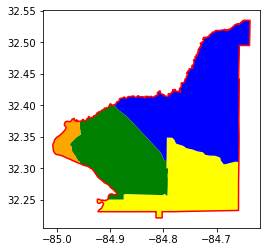

In [76]:
ax = vest_ga_20[vest_ga_20["CTYNAME"]=="CHATTAHOOCHEE"].boundary.plot(color="red")
ga_shapefile[ga_shapefile["CTYNAME"]=="CHATTAHOOCHEE"].plot(ax = ax,color="yellow")
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"].plot(ax = ax,color="blue")
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"].plot(ax = ax,color="green")
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"].plot(ax = ax,color="orange")

#### Merge the four VTDS and plot the result

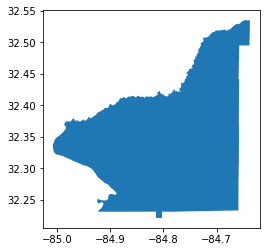

In [77]:
index_fort_1 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"].index.values[0]
index_fort_2 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"].index.values[0]
index_fort_3 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"].index.values[0]

prec2combine = [ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = ga_shapefile.crs)

ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER","geometry"]=new_fort.unary_union
ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER","unique_ID"]="053-ACTIVITY CENTER (Includes FTBEN 1-3)"
ga_shapefile.loc[ga_shapefile["unique_ID"]=="053-ACTIVITY CENTER (Includes FTBEN 1-3)"].plot()
ga_shapefile = ga_shapefile.drop([index_fort_1,index_fort_2,index_fort_3])
ga_shapefile.reset_index(drop=True, inplace=True)

### Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary - Completed
All of the merges seem to have already been completed, VEST doesn't provide much detail on the 2/13 boundary adjustment, but it's reasonable to assume that that's also been performed, as the others have been. Any differences will be plotted in the shapefile validation.

     PRECINCT_N
1463         03
1464         04
2181         02
2219         05
2224         13
2225         08
2226         16
2228         01


<AxesSubplot:>

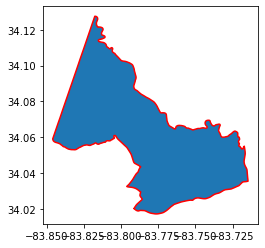

In [78]:
print(ga_shapefile[ga_shapefile["CTYNAME"]=="BARROW"][["PRECINCT_N"]])
ax = ga_shapefile[(ga_shapefile["CTYNAME"]=="BARROW")&(ga_shapefile["PRECINCT_N"]=="02")].plot()
vest_ga_20[(vest_ga_20["CTYNAME"]=="BARROW")&(vest_ga_20["PRECINCT_N"]=="02 BETHLEHEM CHURCH - 211")].boundary.plot(ax = ax,color="red")

### Bartow: Split Cassville/Hamilton Crossing - Completed
This seems to have been performed already in the shapefile.

In [79]:
ga_shapefile[(ga_shapefile["CTYNAME"]=="BARTOW") & (ga_shapefile["PRECINCT_N"].isin(["CASSVILLE","HAMILTON CROSSING"]))][["PRECINCT_N"]]

,PRECINCT_N
1900,HAMILTON CROSSING
1901,CASSVILLE


### Candler: Merge Candler/Metter as Jack Strickland Comm Center - Completed
This seems to have been performed already in the shapefile as this is the only precinct in Candler.

In [80]:
ga_shapefile[ga_shapefile["CTYNAME"]=="CANDLER"][["PRECINCT_N"]]

,PRECINCT_N
998,JACK STRICKLAND COMMUNITY CENTER


### Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C -  Completed
All of the splits and realignments already seem to have already been completed.

In [81]:
ga_shapefile[(ga_shapefile["CTYNAME"]=="CHATHAM") & (ga_shapefile["PRECINCT_I"].str[0:4].isin(["7-07","8-16","7-12","7-16"]))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1329,0517-16C,0517-16C,7-16C,POOLER RECREATION CENTER GYMNASIUM,CHATHAM,025,051,"POLYGON ((-81.30470 32.09313, -81.30247 32.092...",051-POOLER RECREATION CENTER GYMNASIUM 7-16C
1330,0517-12C,0517-12C,7-12C,POOLER RECREATION CENTER GYMNASIUM,CHATHAM,025,051,"MULTIPOLYGON (((-81.24078 32.08290, -81.24100 ...",051-POOLER RECREATION CENTER GYMNASIUM 7-12C
1350,0517-07C,0517-07C,7-07C,ROTHWELL BAPTIST CHURCH,CHATHAM,025,051,"POLYGON ((-81.26321 32.12098, -81.26681 32.122...",051-ROTHWELL BAPTIST CHURCH
1351,0518-16C,0518-16C,8-16C,MIGHTY EIGHTH MUSEUM,CHATHAM,025,051,"POLYGON ((-81.28350 32.16288, -81.28333 32.165...",051-MIGHTY EIGHTH MUSEUM


<AxesSubplot:>

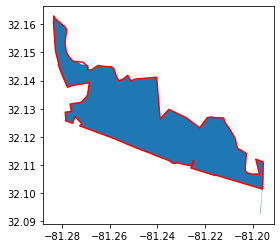

In [82]:
ax = ga_shapefile[(ga_shapefile["CTYNAME"]=="CHATHAM")&(ga_shapefile["PRECINCT_I"]=="7-07C")].plot()
vest_ga_20[(vest_ga_20["CTYNAME"]=="CHATHAM")&(vest_ga_20["PRECINCT_I"]=="7-07C")].boundary.plot(ax = ax,color="red")

### Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile - Completed

<AxesSubplot:>

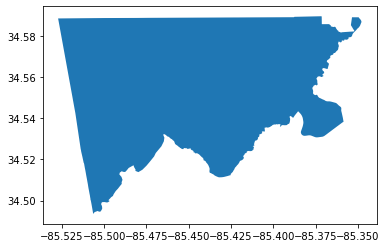

In [83]:
ga_shapefile[ga_shapefile["PRECINCT_N"]=="CLOUDLAND-TELOGA"].plot()

(34.493477, 34.589756)

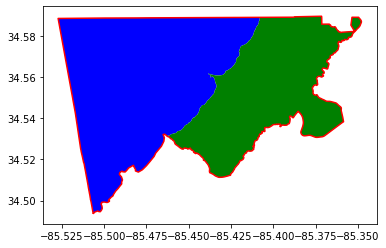

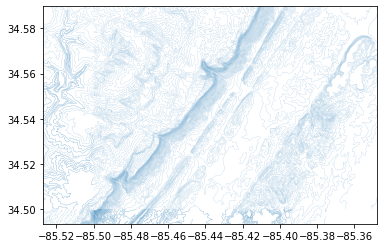

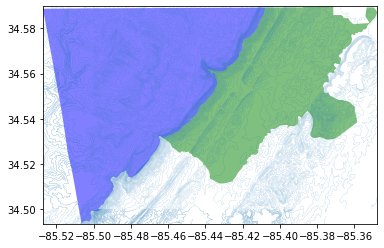

In [84]:
#Printing with the merged precinct on top
ax2 = vest_ga_20[vest_ga_20["PRECINCT_N"]=="CLOUDLAND"].plot(color="blue")
vest_ga_20[vest_ga_20["PRECINCT_N"]=="TELOGA"].plot(ax=ax2,color="green")
ga_shapefile[ga_shapefile["PRECINCT_N"]=="CLOUDLAND-TELOGA"].boundary.plot(ax = ax2,color="red")

#Import the topo lines
elev_contour_1 = gp.read_file("./raw-from-source/Topographic_Lines/VECTOR_Dougherty_Gap_GA_7_5_Min_Shape/Elev_Contour.shp")
elev_contour_2 = gp.read_file("./raw-from-source/Topographic_Lines/VECTOR_Jamestown_AL_7_5_Min_Shape/Elev_Contour.shp")

#Plot the elev_countours
ax3 = elev_contour_1.plot(linewidth=0.1)
elev_contour_2.plot(ax=ax3,linewidth=0.1)
minx, miny, maxx, maxy = ga_shapefile[ga_shapefile["PRECINCT_N"]=="CLOUDLAND-TELOGA"].total_bounds
ax3.set_xlim(minx, maxx)
ax3.set_ylim(miny, maxy)

#Confirm that the precincts are really split on a ridgeline
ax4 = vest_ga_20[vest_ga_20["PRECINCT_N"]=="CLOUDLAND"].plot(color="blue",alpha=.5)
vest_ga_20[vest_ga_20["PRECINCT_N"]=="TELOGA"].plot(ax=ax4,color="green",alpha=.5)
elev_contour_1.plot(ax=ax4,linewidth=0.1)
elev_contour_2.plot(ax=ax4,linewidth=0.1)
minx, miny, maxx, maxy = ga_shapefile[ga_shapefile["PRECINCT_N"]=="CLOUDLAND-TELOGA"].total_bounds
ax4.set_xlim(minx, maxx)
ax4.set_ylim(miny, maxy)

#As you can see the precinct is not plotted exactly on 

In [85]:
print(vest_ga_20.columns)

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA', 'geometry',
       'unique_ID'],
      dtype='object')


In [86]:
#Merge the election results to check those
data_columns = ['G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL']

for i in data_columns:
        ga_election.loc[ga_election["unique_ID"]=="055-CLOUDLAND",i]=int(ga_election.loc[ga_election["unique_ID"]=="055-CLOUDLAND",i])+int(ga_election.loc[ga_election["unique_ID"]=="055-TELOGA",i])

ga_election.loc[ga_election['precinct']=="CLOUDLAND",'unique_ID']="055-CLOUDLAND-TELOGA"       
ga_election = ga_election[ga_election["unique_ID"]!="055-TELOGA"]

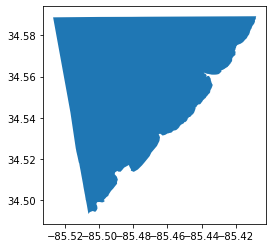

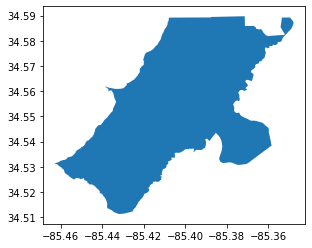

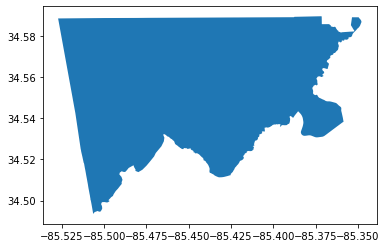

In [87]:
vest_ga_20[vest_ga_20["PRECINCT_N"]=="CLOUDLAND"].plot()
vest_ga_20[vest_ga_20["PRECINCT_N"]=="TELOGA"].plot()

prec2combine = [vest_ga_20.loc[vest_ga_20["PRECINCT_N"]=="CLOUDLAND"],vest_ga_20.loc[vest_ga_20["PRECINCT_N"]=="TELOGA"]]
new_prec = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = vest_ga_20.crs)

vest_ga_20.loc[vest_ga_20["PRECINCT_N"]=="CLOUDLAND","geometry"]=new_prec.unary_union

vest_ga_20[vest_ga_20["PRECINCT_N"]=="CLOUDLAND"].plot()

for i in data_columns:
        vest_ga_20.loc[vest_ga_20["PRECINCT_N"]=="CLOUDLAND",i]=int(vest_ga_20.loc[vest_ga_20["PRECINCT_N"]=="CLOUDLAND",i])+int(vest_ga_20.loc[vest_ga_20["PRECINCT_N"]=="TELOGA",i])

vest_ga_20.loc[vest_ga_20["PRECINCT_N"]=="CLOUDLAND",'unique_ID']="055-CLOUDLAND-TELOGA"       
vest_ga_20 = vest_ga_20[vest_ga_20["PRECINCT_N"]!="TELOGA"]
vest_ga_20.reset_index(inplace=True,drop=True)


### Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5 - Completed
These changes appear to have been performed already

In [88]:
precinct_list = ["ELLENWOOD 1","ELLENWOOD 2","JONESBORO 1","JONESBORO 17","JONESBORO 19",
                "LOVEJOY 3","LOVEJOY 6", "LOVEJOY 7", "MORROW 3","MORROW 11","MORROW 5", "MORROW 10", "OAK 3", "OAK 5"]

ga_shapefile[(ga_shapefile["CTYNAME"]=="CLAYTON")&(ga_shapefile["PRECINCT_N"].isin(precinct_list))][["PRECINCT_N"]]

,PRECINCT_N
217,LOVEJOY 7
235,MORROW 5
236,MORROW 10
255,OAK 3
287,LOVEJOY 3
290,JONESBORO 19
291,JONESBORO 17
320,JONESBORO 1
797,LOVEJOY 6
1760,ELLENWOOD 2


### Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B - Completed

In [89]:
precinct_list = ["BELLS FERRY 03","BELLS FERRY 04","DOBBINS 01","DOBBINS 02",
                "SMYRNA 3A","SMYRNA 3B", "MARIETTA 3A", "MARIETTA 3B"]

ga_shapefile[(ga_shapefile["CTYNAME"]=="COBB")&(ga_shapefile["PRECINCT_N"].isin(precinct_list))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1833,067BF03,067BF03,BF03,BELLS FERRY 03,COBB,033,067,"POLYGON ((-84.52954 34.07560, -84.52952 34.075...",067-BELLS FERRY 03
1847,067MR3B,067MR3B,MR3B,MARIETTA 3B,COBB,033,067,"MULTIPOLYGON (((-84.56369 33.93119, -84.56377 ...",067-MARIETTA 3B
1849,067SN3A,067SN3A,SN3A,SMYRNA 3A,COBB,033,067,"MULTIPOLYGON (((-84.51112 33.89066, -84.51150 ...",067-SMYRNA 3A
1851,067SN3B,067SN3B,SN3B,SMYRNA 3B,COBB,033,067,"POLYGON ((-84.52645 33.88128, -84.52632 33.881...",067-SMYRNA 3B
1852,067DI01,067DI01,DI01,DOBBINS 01,COBB,033,067,"MULTIPOLYGON (((-84.53490 33.90277, -84.53554 ...",067-DOBBINS 01
1860,067BF04,067BF04,BF04,BELLS FERRY 04,COBB,033,067,"POLYGON ((-84.55954 34.06219, -84.55985 34.062...",067-BELLS FERRY 04
1867,067MR3A,067MR3A,MR3A,MARIETTA 3A,COBB,033,067,"POLYGON ((-84.58079 33.94491, -84.58083 33.944...",067-MARIETTA 3A
1881,067DI02,067DI02,DI02,DOBBINS 02,COBB,033,067,"MULTIPOLYGON (((-84.51112 33.89066, -84.51111 ...",067-DOBBINS 02


### Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps - Completed

Any precincts that VEST re-aligned that weren't will print below

In [90]:
prec_list = ["BESSIE THOMAS CENTER","SECOND MOUNT MORIAH BAPTIST CHURCH" ,"HARLEM SENIOR CENTER",
             "HARLEM BRANCH LIBRARY","BLANCHARD PARK","MTZ COL FIRE HDQTR."]
  

print(ga_shapefile[(ga_shapefile["CTYNAME"]=="COLUMBIA")&(ga_shapefile["PRECINCT_N"].isin(prec_list))]["PRECINCT_N"])

346                         BLANCHARD PARK
1047                  BESSIE THOMAS CENTER
1194    SECOND MOUNT MORIAH BAPTIST CHURCH
1197                  HARLEM SENIOR CENTER
1201                 HARLEM BRANCH LIBRARY
1254                   MTZ COL FIRE HDQTR.
Name: PRECINCT_N, dtype: object


<AxesSubplot:>

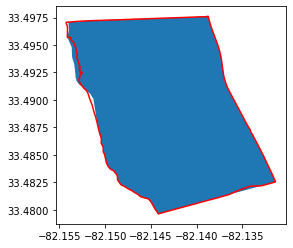

In [91]:
ax = vest_ga_20[(vest_ga_20["CTYNAME"]=="COLUMBIA")&(vest_ga_20["PRECINCT_N"]=="BLANCHARD PARK")].plot()
ga_shapefile[(ga_shapefile["CTYNAME"]=="COLUMBIA")&(ga_shapefile["PRECINCT_N"]=="BLANCHARD PARK")].boundary.plot(ax = ax,color="red")

### Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre - Completed

In [92]:
ga_shapefile[ga_shapefile["PRECINCT_N"]=="THE NEWNAN CENTRE"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
767,07718,07718,18,THE NEWNAN CENTRE,COWETA,038,077,"POLYGON ((-84.68711 33.36559, -84.68728 33.365...",077-THE NEWNAN CENTRE


In [93]:
ga_shapefile[ga_shapefile["CTYNAME"]=="COWETA"]["PRECINCT_N"].unique()

array(['DRESDEN', 'CEDAR CREEK', 'MADRAS', 'CENTRAL', 'GREENTOP',
       'WELCOME', 'SMOKEY ROAD', 'WESTSIDE', 'NEWNAN', 'EXPO CENTER',
       'PANTHER CREEK', 'MORELAND', 'PINE ROAD', 'GRANTVILLE',
       'COWETA CENTRAL LIBRARY', 'THOMAS CROSSROADS', 'TURIN', 'HARALSON',
       'SENOIA', 'SHARPSBURG', 'FISCHER ROAD', 'CANNONGATE', 'RAYMOND',
       'THE NEWNAN CENTRE', 'WHITE OAK', 'NORTHSIDE'], dtype=object)

### Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035 - COMPLETED

In [94]:
precinct_list = ["121CP07A","121CP07D","121CH01","121CH04B",
                "121SS29A","121SS29B", "121UC031", "121UC035"]

print(ga_shapefile[(ga_shapefile["DISTRICT"].isin(precinct_list))]["DISTRICT"])

2330    121SS29A
2331    121SS29B
2534    121UC031
2550    121UC035
2603     121CH01
2607    121CH04B
2625    121CP07A
2629    121CP07D
Name: DISTRICT, dtype: object


In [95]:
prec2combine = [ga_shapefile.loc[ga_shapefile["DISTRICT"]=="121CP07D"],ga_shapefile[ga_shapefile["DISTRICT"]=="121CP07A"]]
new_shp = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = ga_shapefile.crs)
ga_shapefile.loc[ga_shapefile["DISTRICT"]=="121CP07D","geometry"]=new_shp.unary_union
ga_shapefile = ga_shapefile[ga_shapefile["DISTRICT"]!="121CP07A"]
ga_shapefile.reset_index(drop=True, inplace=True)

prec2combine = [ga_shapefile.loc[ga_shapefile["DISTRICT"]=="121CH04B"],ga_shapefile[ga_shapefile["DISTRICT"]=="121CH01"]]
new_shp = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = ga_shapefile.crs).unary_union
ga_shapefile.loc[ga_shapefile["DISTRICT"]=="121CH01","geometry"]=gp.GeoDataFrame(geometry=[new_shp]).geometry.values
ga_shapefile = ga_shapefile[ga_shapefile["DISTRICT"]!="121CH04B"]
ga_shapefile.reset_index(drop=True, inplace=True)

prec2combine = [ga_shapefile.loc[ga_shapefile["DISTRICT"]=="121SS29B"],ga_shapefile[ga_shapefile["DISTRICT"]=="121SS29A"]]
new_shp = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = ga_shapefile.crs)
ga_shapefile.loc[ga_shapefile["DISTRICT"]=="121SS29A","geometry"]=new_shp.unary_union
ga_shapefile = ga_shapefile[ga_shapefile["DISTRICT"]!="121SS29B"]
ga_shapefile.reset_index(drop=True, inplace=True)

prec2combine = [ga_shapefile.loc[ga_shapefile["DISTRICT"]=="121UC031"],ga_shapefile[ga_shapefile["DISTRICT"]=="121UC035"]]
new_shp = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = ga_shapefile.crs)
ga_shapefile.loc[ga_shapefile["DISTRICT"]=="121UC031","geometry"]=new_shp.unary_union
ga_shapefile = ga_shapefile[ga_shapefile["DISTRICT"]!="121UC035"]
ga_shapefile.reset_index(drop=True, inplace=True)

<AxesSubplot:>

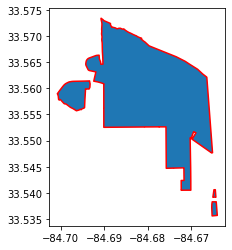

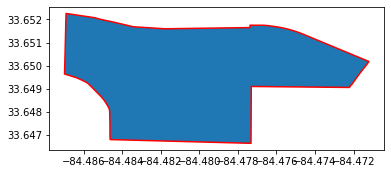

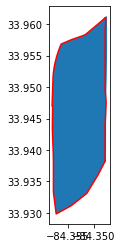

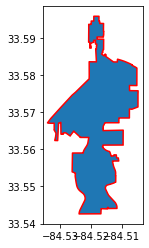

In [96]:
ax = ga_shapefile[(ga_shapefile["DISTRICT"]=="121CH01")].plot()
vest_ga_20[(vest_ga_20["DISTRICT"]=="121CH01")].boundary.plot(ax=ax,color="red")

ax = ga_shapefile[(ga_shapefile["DISTRICT"]=="121CP07D")].plot()
vest_ga_20[(vest_ga_20["DISTRICT"]=="121CP07D")].boundary.plot(ax=ax,color="red")

ax = ga_shapefile[(ga_shapefile["DISTRICT"]=="121SS29A")].plot()
vest_ga_20[(vest_ga_20["DISTRICT"]=="121SS29A")].boundary.plot(ax=ax,color="red")

ax = ga_shapefile[(ga_shapefile["DISTRICT"]=="121UC031")].plot()
vest_ga_20[(vest_ga_20["DISTRICT"]=="121UC031")].boundary.plot(ax=ax,color="red")

### DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits - Completed

In [97]:
precinct_list = ['CLARKSTON COMMUNITY CENTER (CLA)','CLARKSTON (CLA)']
ga_shapefile[(ga_shapefile["CTYNAME"]=="DEKALB")&(ga_shapefile["PRECINCT_N"].isin(precinct_list))]["PRECINCT_N"]

1912                     CLARKSTON (CLA)
1979    CLARKSTON COMMUNITY CENTER (CLA)
Name: PRECINCT_N, dtype: object

<AxesSubplot:>

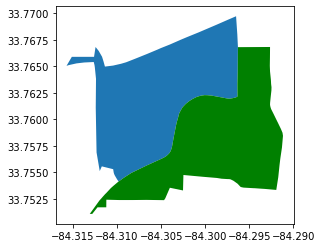

In [98]:
ax = ga_shapefile[(ga_shapefile["CTYNAME"]=="DEKALB")&(ga_shapefile["PRECINCT_N"]=="OAKHURST (DEC)")].plot()
ga_shapefile[(ga_shapefile["CTYNAME"]=="DEKALB")&(ga_shapefile["PRECINCT_N"]=='DECATUR (DEC)')].plot(ax=ax,color="green")

<AxesSubplot:>

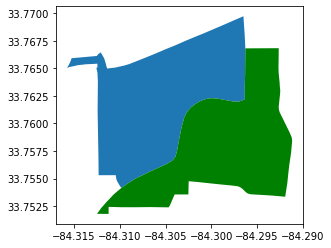

In [99]:
ax = vest_ga_20[(vest_ga_20["CTYNAME"]=="DEKALB")&(vest_ga_20["PRECINCT_N"]=='OAKHURST')].plot()
vest_ga_20[(vest_ga_20["CTYNAME"]=="DEKALB")&(vest_ga_20["PRECINCT_N"]=='DECATUR')].plot(ax = ax,color="green")
 

#### Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G
There isn't enough detail to check these changes.

### Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU - Completed

In [100]:
ga_shapefile[ga_shapefile["CTYNAME"]=="LOWNDES"]["PRECINCT_N"].unique()

array(['NORTHGATE ASSEMBLY', 'CLYATTVILLE', 'S LOWNDES', 'DASHER',
       'NAYLOR', 'HAHIRA TRAIN DEPOT', 'MILDRED', 'MT CALVARY',
       'JAYCEE SHACK', 'TRINITY', 'RAINWATER', 'NORTHSIDE', 'VSU UC # 2'],
      dtype=object)

### Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits - Completed

<AxesSubplot:>

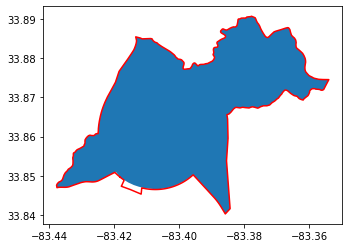

In [101]:
ga_shapefile[ga_shapefile["CTYNAME"]=="OCONEE"]["PRECINCT_N"].unique()

ax = ga_shapefile[ga_shapefile["PRECINCT_N"]=='CITY HALL'].plot()
vest_ga_20[vest_ga_20["PRECINCT_N"]=='CITY HALL'].boundary.plot(ax = ax,color="red")

### Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019 - Completed

In [102]:
ga_shapefile[ga_shapefile["CTYNAME"]=="PAULDING"].shape

(19, 9)

### Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman - Completed

In [103]:
ga_shapefile[ga_shapefile["CTYNAME"]=="RANDOLPH"]["PRECINCT_N"]

276                COLEMAN
512               SHELLMAN
516             SPRINGVALE
517               CUTHBERT
518            BENEVOLENCE
522    CUTHBERT/COURTHOUSE
Name: PRECINCT_N, dtype: object

### Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps - Completed

<AxesSubplot:>

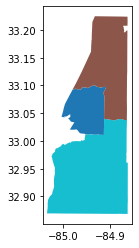

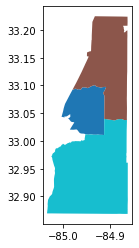

In [104]:
ga_shapefile[ga_shapefile["CTYNAME"]=="TROUP"]["PRECINCT_N"]

prec_list = ["GARDNER NEWMAN","HOGANSVILLE","ROSEMONT"]

ga_shapefile[(ga_shapefile["CTYNAME"]=="TROUP")&(ga_shapefile["PRECINCT_N"].isin(prec_list))].plot(column="PRECINCT_N")
vest_ga_20[(vest_ga_20["CTYNAME"]=="TROUP")&(vest_ga_20["PRECINCT_N"].isin(prec_list))].plot(column="PRECINCT_N")

### Towns: Merge Macedonia/Tate City - Completed

In [105]:
ga_shapefile[ga_shapefile["CTYNAME"]=="TOWNS"]["PRECINCT_N"].unique()

array(['YOUNG HARRIS', 'HIAWASSEE', 'MACEDONIA'], dtype=object)

### Wilkes: Align 1/2A boundary with the voter file - Don't have voter file to complete this

<AxesSubplot:>

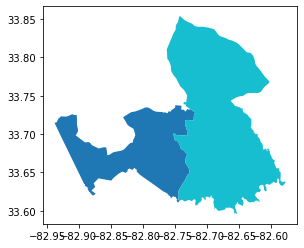

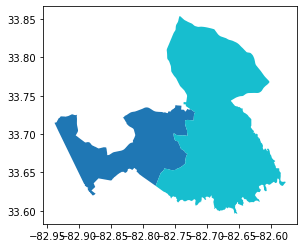

In [106]:

prec_list = ["2A","1"]

ga_shapefile[(ga_shapefile["CTYNAME"]=="WILKES")&(ga_shapefile["PRECINCT_I"].isin(prec_list))].plot(column="PRECINCT_I")
vest_ga_20[(vest_ga_20["CTYNAME"]=="WILKES")&(vest_ga_20["PRECINCT_I"].isin(prec_list))].plot(column="PRECINCT_I")

### Attempt to Join

In [107]:
join_attempt_3 = pd.merge(ga_election,ga_shapefile,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

left_only.to_csv("./source_join_elections.csv")
right_only.to_csv("./source_join_shapes.csv")

both          2420
left_only      258
right_only     258
Name: _merge, dtype: int64


In [108]:
example_fips_dict ={'013-01': '013-01 BETHLEHEM COMMUNITY CENTER',
 '013-02': '013-02 BETHLEHEM CHURCH - 211',
 '013-03': '013-03 HMONG NEW HOPE ALLIANCE CHURCH',
 '013-04': '013-04 COVENANT LIFE SANCTUARY',
 '013-05': '013-05 FIRE STATION 1 (STATHAM)',
 '013-08': '013-08 FIRST BAPTIST CHURCH WINDER',
 '013-13': '013-13 WINDER COMMUNITY CENTER',
 '013-16': '013-16 THE CHURCH AT WINDER',
 '023-1': '023-FAIRGROUND',
 '029-J.F.GREGORY PARK': '029-JF GREGORY PARK',
 '029-PUBLIC SAFETY COMPX': '029-PUBLIC SAFETY COMPLEX',
 '029-RH RECREATION COMPX': '029-RH REC COMPLEX',
 '033-ST. CLAIR': '033-ST CLAIR',
 '039-ST. MARYS': '039-ST MARYS',
 '039-WEST SAINT MARYS': '039-WEST ST MARYS',
 '043-JACK STRICKLAND COMMUNITY CENTER': '043-JACK STRICKLAND COMM CENTER',
 '045-UNIVERSITY OF W. GA': '045-UNIVERSITY OF W GA',
 '049-ST. GEORGE': '049-ST GEORGE',
 '051-J E A': '051-JEA BUILDING',
 '051-ST. THOMAS EPISCOPAL CHURCH': '051-ST THOMAS EPISCOPAL CHURCH',
 '051-ISLANDS CHRISTIAN CH': '051-ISLANDS CHRISTIAN CHURCH',
 '051-FELLOWSHIP OF LOVE COMMUNITY CHURCH': '051-FELLOWSHIP OF LOVE CHURCH',
 '051-CHRIST COMMUNITY CHURCH AT MORNINGSIDE': '051-CHRIST COMMUNITY CHURCH',
 '051-COKESBURY METHODIST CHURCH': '051-COKESBURY METHODIST',
 '051-SOUTHSIDE BAPTIST CH': '051-SOUTHSIDE BAPTIST CHURCH',
 '051-THUNDERBOLT MUN COMP': '051-THUNDERBOLT MUNI COMPLEX',
 '051-FRANK MURRAY COMMUNITY CENTER': '051-FRANK MURRAY COMM CENTER',
 '051-SAINT FRANCIS EPISCOPAL CHURCH': '051-ST FRANCIS EPISCOPAL CHURCH',
 '051-FIRST BAPTIST CHURCH OF THE ISLAND': '051-FIRST BAPTIST OF THE ISLAND',
 '051-WILMINGTON ISLAND UNITED METHODIST CHURCH': '051-WILMINGTON ISLAND UMC',
 '051-WILMINGTON ISLAND PRESBYTERIAN CHURCH': '051-WILMINGTON ISLAND PRES CHURCH',
 '051-TYBEE IS SCH CAFE': '051-TYBEE ISLAND SCHOOL CAFE',
 '051-SKID IS PRES CHURCH': '051-SKIDAWAY ISLAND PRES CHURCH',
 '051-SKIDAWAY ISLAND STAT': '051-SKIDAWAY ISLAND STATE PARK',
 '051-SENIOR CITIZEN CENTER': '051-SENIOR CITIZENS CENTER',
 '051-BUTLER PRESBYTERIAN CHURCH ED BLDG': '051-BUTLER PRESBYTERIAN CHURCH',
 '051-LIBERTY CITY COMMUNITY CENTER': '051-LIBERTY CITY COMM CTR',
 '051-STATION 1': '051-ELKS LODGE',
 '051-SAVANNAH PRIMITIVE BAPTIST CHURCH': '051-SAVANNAH PRIMITIVE BC',
 '051-LARGO-TIBET ELEMENTA': '051-LARGO-TIBET ELEMENTARY',
 '051-WHITE BLUFF PRESBYTERIAN CHURCH': '051-WHITE BLUFF PRESBYTERIAN',
 '051-WINDSOR FOREST BAPTIST CHURCH SCHOOL': '051-WINDSOR FOREST BAPTIST',
 '051-CRUSADER COMMUNITY CENTER': '051-CRUSADER COMM CENTER',
 '051-STATION 3': '051-GEORGETOWN ELEMENTARY',
 '051-GARDEN CITY SENIOR CENTER': '051-GARDEN CITY SENIOR CTR',
 '051-PB EDWARDS GYMNASIUM': '051-PB EDWARDS GYM',
 '051-LAKE SHORE COMMUNITY CENTER': '051-LAKE SHORE COMM CTR',
 '051-BLOOMINGDALE COMMUNITY CENTER': '051-BLOOMINGDALE COMM CTR',
 '051-SAVANNAH HOLY CHURCH OF GOD': '051-SAVANNAH HOLY C OF G',
 '051-PROGRESSIVE REC CTR': '051-PROGRESSIVE REC CENTER',
 '051-COURTYARD BY MARRIOTT': '051-SEVENTH DAY ADV CHURCH',
 '051-SOUTHSIDE FIRE TRAINING CENTER': '051-SOUTHSIDE FIRE TRNG CTR',
 '051-WEST BROAD STREET YMCA': '051-W BROAD ST YMCA',
 '051-TOMPKINS RECREATION CENTER': '051-TOMPKINS REC CENTER',
 '051-WOODVILLE-TOMPKINS TECHNICAL INST': '051-WOODVILLE-TOMPKINS TI',
 '051-RESURRECTION OF OUR LORD CATHOLIC CHURCH': '051-RESURRECTION OF OUR LORD CHURCH',
 '051-CARVER HEIGHTS COMM': '051-CARVER HEIGHTS COMM CTR',
 '051-BUTLER ELEMENTARY SC': '051-BUTLER ELEMENTARY',
 '051-SAVANNAH CHRISTIAN S': '051-SAVANNAH CHRISTIAN',
 '051-FIRST BAPTIST CH GARDEN CITY': '051-GARDEN CITY REC CENTER',
 '051-MIGHTY EIGHTH MUSEUM': '051-ROYAL CINEMAS AND IMAX',
 '051-POOLER RECREATION CENTER GYMNASIUM 7-12C':'051-POOLER CHURCH',
 '051-POOLER RECREATION CENTER GYMNASIUM 7-16C':'051-POOLER REC CENTER GYM',
 '053-ACTIVITY CENTER': '053-ACTIVITY CENTER (Includes FTBEN 1-3)',
 '063-OAK5': '063-OAK 5',
 '067-MCEACHERN': '067-MCEACHERN 01',
 '067-MOUNT BETHEL 01': '067-MT BETHEL 01',
 '067-MOUNT BETHEL 03': '067-MT BETHEL 03',
 '067-MOUNT BETHEL 04': '067-MT BETHEL 04',
 '073-BLUERIDGE ELEMENTARY': '073-BLUE RIDGE ELEMENTARY',
 '073-CHRIST CHURCH, PRESBYTERIAN': '073-CHRIST CHURCH PRESBYTERIAN',
 '073-CHRIST THE KING CH': '073-CHRIST THE KING LUTH CHURCH',
 '073-COL CTY BOARD OF EDU': '073-COL CTY BD OF EDU',
 '073-DAMASCUS BAPT CHURCH': '073-DAMASCUS BAPTIST CHURCH',
 '073-EUBANK/BLANCHARD CTR': '073-EUBANK-BLANCHARD CENTER',
 '073-GROVETOWN METHODIST': '073-GROVETOWN METHODIST CHURCH',
 '073-GROVETOWN DEPT OF PUBLIC SAFETY STATION #2': '073-GROVETOWN PUBLIC SAFETY STATION 2',
 '073-JOURNEY COMM. CHURCH': '073-JOURNEY COMM CHURCH',
 '073-KIOKEE BAPT CHURCH': '073-KIOKEE BAPTIST CHURCH',
 '073-LEWIS METHODIST': '073-LEWIS METHODIST CHURCH',
 '073-LIBERTY PARK - GROVETOWN': '073-LIBERTY PARK-GROVETOWN',
 '073-MTZ COL FIRE HDQTR.': '073-MTZ COL FIRE HDQTR',
 '073-SECOND MT. CARMEL BAPTIST CHURCH': '073-SECOND MT CARMEL BAPTIST CHURCH',
 '073-SECOND MOUNT MORIAH BAPTIST CHURCH': '073-SECOND MT MORIAH BAPTIST CHURCH',
 '073-TRINITY BAPT CHURCH': '073-TRINITY BAPTIST CHURCH',
 '073-WESTSIDE BAPT CHURCH': '073-WESTSIDE BAPTIST CHURCH',
 '073-WOODLAWN BAPT CHURCH': '073-WOODLAWN BAPTIST CHURCH',
 '075-NEW LIFE BAPTIST CH.': '075-NEW LIFE BAPTIST CHURCH',
 '077-THE NEWNAN CENTRE': '077-NEWNAN CENTRE',
 '087-MT. PLEASANT': '087-MT PLEASANT',
 '089-ASHFORD DUNWOODY RD (BHAVN)': '089-ASHFORD DUNWOODY RD',
 '089-ASHFORD PARK ELEM (BHAVN)': '089-ASHFORD PARK ELEM',
 '089-ASHFORD PARKSIDE (BHAVN)': '089-ASHFORD PARKSIDE',
 '089-AUSTIN (DUN)': '089-AUSTIN',
 '089-AVONDALE (AVO)': '089-AVONDALE',
 '089-BOULEVARD (ATL)': '089-BOULEVARD',
 '089-BRIAR VISTA ELEM (UNI & ATL)': '089-BRIAR VISTA ELEM',
 '089-BRIARWOOD (BHAVN)': '089-BRIARWOOD',
 '089-BROCKETT (TUC)': '089-BROCKETT',
 '089-BROCKETT ELEM (TUC)': '089-BROCKETT ELEM',
 '089-BROOKHAVEN (BHAVN)': '089-BROOKHAVEN',
 '089-BURGESS ELEM (ATL)': '089-BURGESS ELEM',
 '089-CHAMBLEE (CHA)': '089-CHAMBLEE',
 '089-CHAMBLEE 2 (CHA)': '089-CHAMBLEE 2',
 '089-CHESNUT ELEM (DUN)': '089-CHESNUT ELEM',
 '089-CLAIREMONT EAST (DEC)': '089-CLAIREMONT EAST',
 '089-CLAIREMONT WEST (DEC)': '089-CLAIREMONT WEST',
 '089-COAN RECREATION CENTER (ATL)': '089-COAN RECREATION CENTER',
 '089-CROSS KEYS HIGH (BHAVN)': '089-CROSS KEYS HIGH',
 '089-DORAVILLE NORTH (DOR)': '089-DORAVILLE NORTH',
 '089-DORAVILLE SOUTH (DOR)': '089-DORAVILLE SOUTH',
 '089-DRESDEN ELEM (CHA)': '089-DRESDEN ELEM',
 '089-DRUID HILLS': '089-DRUID HILLS HIGH',
 '089-DUNWOODY (DUN)': '089-DUNWOODY',
 '089-DUNWOODY 2 (DUN)': '089-DUNWOODY 2',
 '089-DUNWOODY LIBRARY (DUN)': '089-DUNWOODY LIBRARY',
 '089-EAST LAKE (ATL)': '089-EAST LAKE',
 '089-EMORY SOUTH (UNI & ATL)': '089-EMORY SOUTH',
 '089-FERNBANK': '089-FERNBANK ELEM',
 '089-GEORGETOWN (DUN)': '089-GEORGETOWN SQ',
 '089-GLENNWOOD (DEC)': '089-GLENNWOOD',
 '089-HARRIS - MARGARET HARRIS ED': '089-HARRIS-MARGARET HARRIS ED',
 '089-HARRIS - NARVIE J. HARRIS ELEM': '089-HARRIS-NARVIE J HARRIS ELEM',
 '089-HUGH HOWELL (TUC)': '089-HUGH HOWELL',
 '089-HUNTLEY HILLS ELEM (CHA)': '089-HUNTLEY HILLS ELEM',
 '089-IDLEWOOD ELEM (TUC)': '089-IDLEWOOD ELEM',
 '089-JOHNSON ESTATES (ATL)': '089-JOHNSON ESTATES',
 '089-KINGSLEY ELEM (DUN)': '089-KINGSLEY ELEM',
 '089-KITTREDGE ELEM (BHAVN)': '089-KITTREDGE ELEM',
 '089-KNOLLWOOD ELEM': '089-KNOLLWOOD',
 '089-LIN - MARY LIN ELEM (ATL)': '089-LIN-MARY LIN ELEM',
 '089-LITHONIA (LIT)': '089-LITHONIA',
 '089-MATHIS - BOB MATHIS ELEM': '089-MATHIS-BOB MATHIS ELEM',
 '089-METROPOLITAN (ATL)': '089-METROPOLITAN',
 '089-MIDVALE ELEM (TUC)': '089-MIDVALE ELEM',
 '089-MIDWAY ELEM': '089-MIDWAY',
 '089-MILLER - ELDRIDGE L. MILLER ELEM': '089-MILLER-ELDRIDGE L MILLER ELEM',
 '089-MONTCLAIR ELEM (BHAVN)': '089-MONTCLAIR ELEM',
 '089-MONTGOMERY ELEM (BHAVN)': '089-MONTGOMERY ELEM',
 '089-MONTREAL (TUC)': '089-MONTREAL',
 '089-MOUNT VERNON EAST (DUN)': '089-MOUNT VERNON EAST',
 '089-MT.VERNON WEST (DUN)': '089-MOUNT VERNON WEST',
 '089-NORTH PEACHTREE (DUN)': '089-NORTH PEACHTREE',
 '089-OAKHURST (DEC)': '089-OAKHURST',
 '089-PEACHTREE MIDDLE (DUN)': '089-PEACHTREE MIDDLE',
 '089-PINE LAKE (PIN)': '089-PINE LAKE',
 '089-PONCE DE LEON (DEC)': '089-PONCE DE LEON',
 '089-SHAW ELEMENTARY': '089-SHAW-ROBERT SHAW ELEM',
 '089-SILVER LAKE (ATL & BHAVN)': '089-SILVER LAKE',
 '089-SKYLAND (BHAVN)': '089-SKYLAND',
 '089-SMOKE RISE (TUC)': '089-SMOKE RISE',
 '089-SNAPFINGER ROAD NORTH': '089-SNAPFINGER ROAD N',
 '089-SNAPFINGER ROAD SOUTH': '089-SNAPFINGER ROAD S',
 '089-STONE MOUNTAIN (STO)': '089-STONE MTN',
 '089-STONE MOUNTAIN CHAMPION (STO)': '089-STONE MTN CHAMPION',
 '089-STONE MOUNTAIN MIDDLE (TUC)': '089-STONE MTN MIDDLE',
 '089-TILLY MILL ROAD (DUN)': '089-TILLY MILL ROAD',
 '089-TUCKER (TUC)': '089-TUCKER',
 '089-TUCKER LIBRARY (TUC)': '089-TUCKER LIBRARY',
 '089-WINNONA PARK (DEC)': '089-WINNONA PARK',
 '089-WINTERS CHAPEL (DUN)': '089-WINTERS CHAPEL',
 '089-WOODWARD ELEM (BHAVN)': '089-WOODWARD',
'089-CANDLER PARK (ATL)':'089-CANDLER PARK',
'089-CLARKSTON (CLA)':'089-CLARKSTON',
'089-CLARKSTON COMMUNITY CENTER (CLA)':'089-CLARKSTON COMMUNITY CENTER',
'089-DECATUR (DEC)':'089-DECATUR',
'089-GEORGETOWN SQ (DUN)':'089-GEORGETOWN SQ',
'089-LIN-MARY LIN ELEM (ATL)':'089-LIN-MARY LIN ELEM',
'089-MONTGOMERY ELEM  (BHAVN)':'089-MONTGOMERY ELEM',
'089-MOUNT VERNON WEST (DUN)':'089-MOUNT VERNON WEST',
'089-NARVIE J HARRIS ELEM':'089-HARRIS-NARVIE J HARRIS ELEM',
'089-WOODWARD (BHAVN)':'089-WOODWARD',
 '091-CHAUN': '091-CHAUNCEY',
 '091-EMPIR': '091-EMPIRE',
 '091-JAYBI': '091-JAYBIRD',
 '091-MCCRA': '091-MCCRANIE',
 '091-MITCH': '091-MITCHELL',
 '091-MULLI': '091-MULLIS',
 '091-PLAIN': '091-PLAINFIELD',
 '091-PONDT': '091-PONDTOWN',
 '091-RAWLI': '091-RAWLINS',
 '091-VILUL': '091-VILULA',
 '091-YONKE': '091-YONKER',
 '095-ALICE COACHMAN ELEM': '095-ALICE COACHMAN ELEMENTARY',
 '095-INTERNATIONAL STUDIE': '095-INTERNATIONAL STUDIES',
 '095-JACKSON HEIGHTS ELEM': '095-JACKSON HEIGHTS ELEMENTARY',
 '095-LAMAR REESE ELEM SCH': '095-LAMAR REESE ELEMENTARY',
 '095-PALMYRA METH CHURCH': '095-PALMYRA METHODIST',
 '095-PINE BLUFF BAPT CHUR': '095-PINE BLUFF BAPTIST CHURCH',
 '095-PUTNEY 1ST BAPT CHUR': '095-PUTNEY 1ST BAPTIST CHURCH',
 '095-SHERWOOD ELEM SCHOOL': '095-SHERWOOD ELEMENTARY',
 '095-SHILOH BAPTIST CHURC': '095-SHILOH BAPTIST CHURCH',
 '095-TURNER ELEM SCHOOL': '095-TURNER ELEMENTARY',
 '095-WESTTOWN ELEM SCHOOL': '095-WESTTOWN ELEMENTARY',
 '097-EPHESUS BAPTIST CHUR': '097-EPHESUS BAPTIST CHURCH',
 '097-GOLDEN METHODIST CH': '097-GOLDEN METHODIST CHURCH',
 '097-LUTHERAN CHURCH - GS': '097-LUTHERAN CHURCH-GS',
 '097-MIRROR LAKE ELEMENTA': '097-MIRROR LAKE ELEMENTARY',
 '109-VETERANS COMM CTR': '109-VETERANS COMMUNITY CENTER',
 "115-FOSTER'S MILL": '115-FOSTERS MILL',
 '127-BLYTHE ISLAND BAPTIST CHURCH': '127-BLYTHE ISLAND BAPTIST',
 '127-COLLEGE PLACE': '127-COLLEGE PLACE UMC',
 '127-NORTHSIDE CHURCH': '127-NORTHSIDE BAPTIST',
 '127-ST WILLIAM CHURCH': '127-ST WILLIAM CATHOLIC CHURCH',
 '127-STERLING CH. OF GOD': '127-STERLING CHURCH OF GOD',
 '131-CAIRO 4TH DISTR': '131-CAIRO 4TH DISTRICT',
 '131-CAIRO 5TH DISTR': '131-CAIRO 5TH DISTRICT',
 '135-PINKCNEYVILLE A': '135-PINCKNEYVILLE A',
 '137-TOWN OF MOUNT AIRY': '137-TOWN OF MT AIRY',
 '141-ST. MARK': '141-ST MARK',
 '149-COOKSVILLE - CORINTH': '149-COOKSVILLE-CORINTH',
 '151-MT. BETHEL': '151-MT BETHEL',
 '151-MOUNT CARMEL': '151-MT CARMEL',
 '159-MARTIN - BURNEY': '159-MARTIN-BURNEY',
 '171-CHAPPELL MILL V. FD': '171-CHAPPELL MILL VFD',
 '175-FBC - FLC': '175-FBC-FLC',
 '175-FIRE DEPT STA #5': '175-FIRE DEPT STA 5',
 '175-LCFS #10 (VALAMBROSIA)': '175-LCFS 10 VALAMBROSIA',
 '175-RURAL FIRE STA #17': '175-RURAL FIRE STA 17',
 '175-W T ADAMS FIRE STA #18': '175-W T ADAMS FIRE STA 18',
 '177-#3 CJC': '177-CJC',
 '177-#9 CENTURY FIRE STAT': '177-CENTURY FIRE STATION',
 '177-#1 CHOKEE': '177-CHOKEE',
 '177-#6 FIRST BAPTIST': '177-FIRST BAPTIST',
 '177-#8 FLINT REFORMED BAPTIST': '177-FLINT REFORMED BAPTIST',
 '177-#5 FRIENDSHIP BAPT.': '177-FRIENDSHIP BAPTIST',
 '177-#4 LEESBURG': '177-LEESBURG',
 '177-#10 REDBONE': '177-REDBONE',
 '177-#7 SDA CHURCH': '177-SDA CHURCH',
 '177-#2 SMITHVILLE': '177-SMITHVILLE',
 '179-MEMORIAL DR. EAST': '179-MEMORIAL DR EAST',
 '181-FAITH TEMPLE OF LINC': '181-FAITH TEMPLE OF LINCOLN',
 '199-UPPER 9TH -ALVATON': '199-ALVATON',
 '199-THIRD-DURAND': '199-DURAND',
 '199-MIDDLE 9TH-GAY': '199-GAY',
 '199-8TH-GREENVILLE': '199-GREENVILLE',
 '199-7TH-ODESSADALE': '199-ODESSADALE',
 '199-2ND-WARM SPRINGS': '199-WARM SPRINGS',
 '199-LOWER 9TH-WOODBURY': '199-WOODBURY',
 '211-3. BETH/SPRINGFIELD': '211-BETH/SPRINGFIELD',
 '211-4. CENTRAL MORGAN': '211-CENTRAL MORGAN',
 '211-5. CLACKS CHAPEL': '211-CLACKS CHAPEL',
 '211-2. EAST MORGAN': '211-EAST MORGAN',
 '211-7. NORTH MORGAN': '211-NORTH MORGAN',
 '211-1. NORTHEAST MORGAN': '211-NORTHEAST MORGAN',
 '211-6. WEST MORGAN': '211-WEST MORGAN',
 '215-GENTIAN/REESE @LDS': '215-GENTIAN/REESE',
 '215-ST. PETER': '215-ST PETER',
 '223-DIANNE WRIGHT INNOVATION CENTER': '223-D WRIGHT INNOVATION CTR',
 '223-THE EVENTS PLACE': '223-EVENTS PLACE',
 '223-LEGACY BAPTIST CHURCH': '223-LEGACY BAPT CHURCH',
 '223-NEBO ELEMENTARY SCHOOL': '223-NEBO ELEM SCHOOL',
 '223-PAULDING SENIOR CENTER': '223-PAULDING SR CENTER',
 '223-POPLAR SPRINGS BAPTIST CHURCH': '223-POPLAR SPRGS BAPT CHURCH',
 '223-RUSSOM ELEMENTARY SCHOOL': '223-RUSSOM ELEMENTARY',
 '223-SHELTON ELEMENTARY SCHOOL': '223-SHELTON ELEMENTARY',
 '223-TAYLOR FARM PARK MEETING ROOM': '223-TAYLOR FARM PARK',
 '223-WATSON GOVT COMPLEX': '223-WATSON GOVT CMPLX',
 '225-BYRON #1': '225-BYRON 1',
 '225-BYRON #2': '225-BYRON 2',
 '225-FORT VALLEY #1': '225-FORT VALLEY 1',
 '225-FORT VALLEY #2': '225-FORT VALLEY 2',
 '225-FORT VALLEY #3': '225-FORT VALLEY 3',
 '229-HACKLEBARNEY/CASON': '229-HACKLEBARNEY-CASON',
 '229-ST JOHNS/BLACKSHEAR': '229-ST JOHNS-BLACKSHEAR',
 '229-SUNSET/SWEAT': '229-SUNSET-SWEAT',
 '243-CUTHBERT/COURTHOUSE': '243-CUTHBERT-COURTHOUSE',
 '251-SCREVEN REC. DEPT.': '251-SCREVEN REC DEPT',
 '261-AG CENTER': '261-AGRI-CENTER',
 '261-REES PARK': '261-REESE PARK',
 '261-THOMSON': '261-THOMPSON',
 '275-TC PUBLIC LIBRARY/JERGER': '275-JERGER',
 '275-LITTLE OCHLOCKNEE BAPTIST': '275-LITTLE OCHLOCKNEE',
 '275-MERRILVILLE': '275-MERRILLVILLE',
 '275-TC PUBLIC LIBRARY/SCOTT': '275-SCOTT',
 '279-513 V.P.D.': '279-513 VPD',
 '279-514 S.T.I.A.L.C.': '279-514 STIALC',
 '285-MCLENDON': '285-MCCLENDON',
 '299-100': '299-District 1',
 '299-200A': '299-District 2A',
 '299-200B': '299-District 2B',
 '315-ABBEVILLE NORTH #2': '315-ABBEVILLE NORTH 2',
 '315-ABBEVILLE SOUTH #5': '315-ABBEVILLE SOUTH 5',
 '315-PINEVIEW #2': '315-PINEVIEW 2',
 '315-PITTS #3': '315-PITTS 3',
 '315-ROCHELLE NORTH #1': '315-ROCHELLE NORTH 1',
 '315-ROCHELLE SOUTH #4': '315-ROCHELLE SOUTH 4',
 '317-SENIOR CITIZEN CENTE': '317-SENIOR CITIZEN CENTER',
 '089-CANDLER - MURPHEY CANDLER ELEM': '089-CANDLER-MURPHEY CANDLER ELEM',
 #The below changes are based on precinct numbers
 '299-300': '299-1231-150B',
 '299-EMERSON PARK BAPTIST CHURCH': '299-1231-150C',
 '299-400': '299-1231-151',
 '299-404': '299-Beach-Bickley',
 '299-405': '299-Haywood',
 '299-406': '299-Jamestown',
 '299-407': '299-Manor',
 '299-408': '299-Millwood',
 '299-409': '299-Waresboro',
 #The below gives justification for this seemingly arbitrary name changes
  #https://www.dekalbcountyga.gov/sites/default/files/users/user305/NOTICE%20OF%20CHANGE%20OF%20POLLING%20PLACES.pdf
 '089-KING - ML KING JR HIGH': '089-SNAPFINGER ROAD',
 '089-EPWORTH (ATL)': '089-CANDLER PARK'
}

In [109]:
ga_shapefile["unique_ID"] = ga_shapefile["unique_ID"].map(example_fips_dict).fillna(ga_shapefile["unique_ID"])

In [110]:
join_attempt_3 = pd.merge(ga_election,ga_shapefile,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

ga_source = join_attempt_3[join_attempt_3["_merge"]=="both"]

left_only.to_csv("./source_join_elections.csv")
right_only.to_csv("./source_join_shapes.csv")

both          2678
left_only        0
right_only       0
Name: _merge, dtype: int64


In [111]:
final_merge = pd.merge(ga_source,vest_ga_20,how="outer",on="unique_ID",indicator="final_merge")

print(final_merge["final_merge"].value_counts())

both          2678
left_only        0
right_only       0
Name: final_merge, dtype: int64


In [112]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_ga_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_ga_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
#print(vals.value_counts())

In [113]:
#Get the area

In [114]:
ga_shapefile[ga_shapefile["unique_ID"]=="089-GLENNWOOD"].area

<ipython-input-114-b0fde230c758>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ga_shapefile[ga_shapefile["unique_ID"]=="089-GLENNWOOD"].area


2040    0.000162
dtype: float64

<AxesSubplot:>

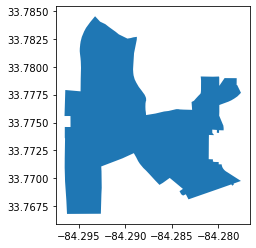

In [115]:
vest_ga_20[vest_ga_20["unique_ID"]=="089-GLENNWOOD"].plot()

1) For 021-HAZZARD 4 difference in area is 3.3706615343443707
2) For 021-HOWARD 1 difference in area is 5.036147171439918
3) For 021-HOWARD 2 difference in area is 2.5699095162291674
4) For 021-HOWARD 3 difference in area is 1.5699552273580146
5) For 021-HOWARD 5 difference in area is 0.5171174601516663
6) For 051-LAKE SHORE COMM CTR difference in area is 1.8155223560836502
7) For 051-RICE CREEK SCHOOL difference in area is 1.8110601544647957
8) For 073-PARKWAY BAPTIST CHURCH difference in area is 0.5694240817096237
9) For 073-PATRIOTS PARK difference in area is 0.859698204711429
Not able to run code for:  089-GLENNWOOD
10) For 089-TUCKER difference in area is 1.6181399475417164
11) For 089-TUCKER LIBRARY difference in area is 1.6181215254617238
12) For 223-BEULAHLAND BAPTIST CHURCH difference in area is 1.9718280831816215
13) For 223-WATSON GOVT CMPLX difference in area is 2.2743294610128006
14) For 285-LONG CANE difference in area is 1.1958253130831367
15) For 285-WEST POINT differen

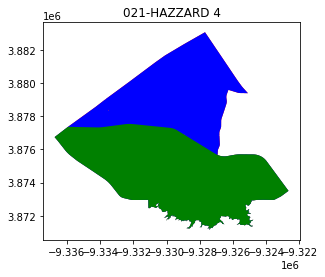

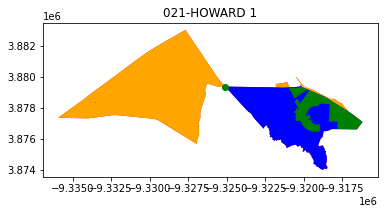

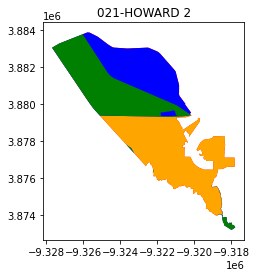

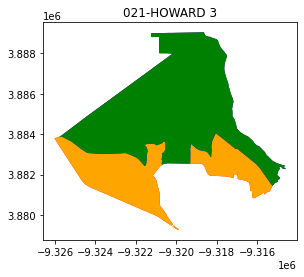

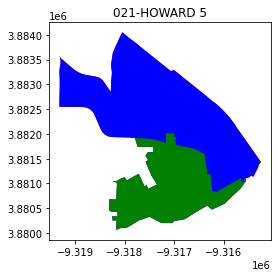

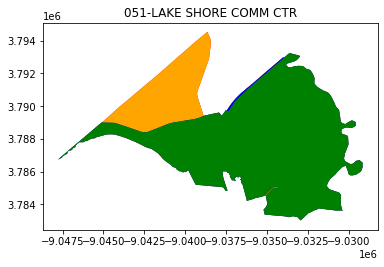

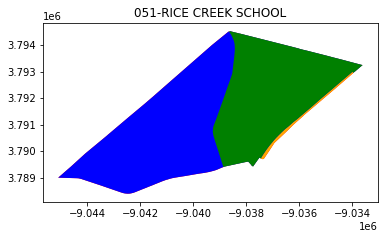

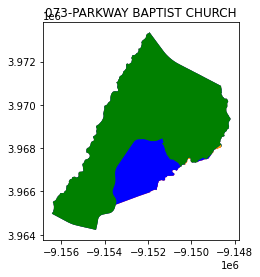

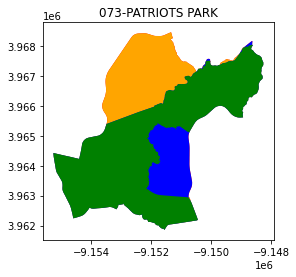

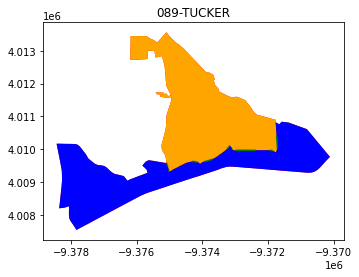

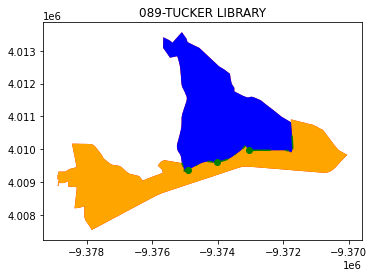

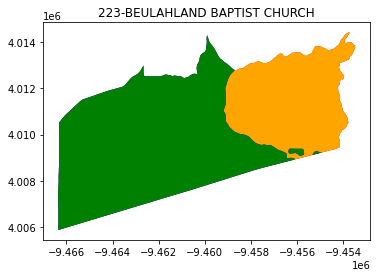

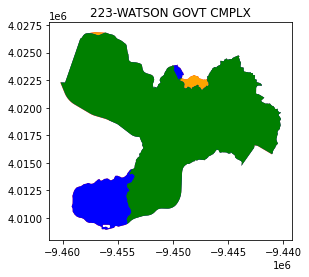

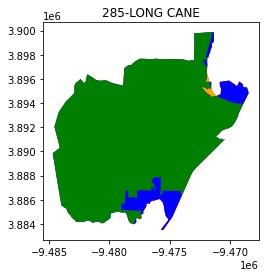

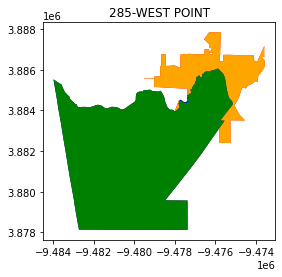

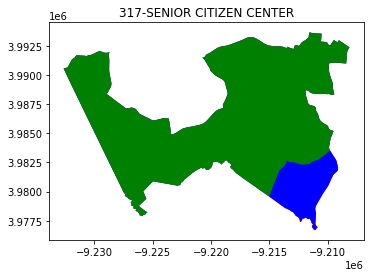

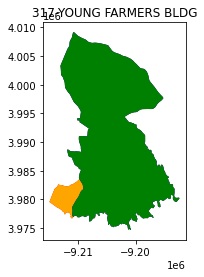

In [116]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    try:
        diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
        intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
        area = float(diff.area/10e6)
        area_list.append(area)
            #print("Area is " + str(area))

        if (area > .5):
            count += 1
            name = source_geoms.iat[i,0]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                base.set_title(name)
            else:
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
    except:
        print("Not able to run code for: ", source_geoms.iat[i,0])
        #diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])


In [117]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2677, 1)
1641 precincts w/ a difference of 0 km^2
993 precincts w/ a difference between 0 and .1 km^2
26 precincts w/ a difference between .1 and .5 km^2
4 precincts w/ a difference between .5 and 1 km^2
7 precincts w/ a difference between 1 and 2 km^2
5 precincts w/ a difference between 2 and 5 km^2
1 precincts w/ a difference greater than 5 km^2


802    0.011073
dtype: float64


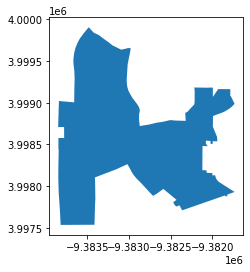

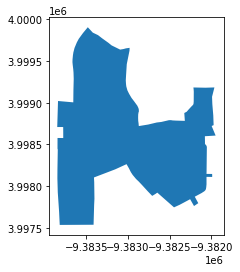

In [118]:
source_geoms[source_geoms["unique_ID"]=="089-GLENNWOOD"].plot()
vest_geoms[vest_geoms["unique_ID"]=="089-GLENNWOOD"].plot()
print((source_geoms[source_geoms["unique_ID"]=="089-GLENNWOOD"].area-vest_geoms[vest_geoms["unique_ID"]=="089-GLENNWOOD"].area)/10e6)
